<a href="https://colab.research.google.com/github/ilyandho/FPL-Optimal-Transfer/blob/main/FPL_points_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 1.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.feature_selection import VarianceThreshold

%matplotlib inline

In [ ]:
plt.rcParams["figure.figsize"] = (12,9)

# Helper functions

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# For the linear model


def Linear_regression(features_train, features_test, target_train, target_test):
    # Before using our data, we need to do feature scaling and we opt for the 'standardization' method of scaling.
    # The 'standardization' is avaliable thorugh the StandardScaler() method
    # Transformers help in batching tasks in a pipepline. In this case, the data is scaled and then a linear regression model is fitted on the scaled data.
    # We use a transformer that takes the regression model and the transformation method
    # The TransformedTargetRegressor does the transformation and when we do the prediction, it automatically does the inverse transformation (scaling) and returns the values
    model = TransformedTargetRegressor(
        LinearRegression(), transformer=StandardScaler())

    # fit the transofrmer on the train data
    model.fit(features_train, target_train)

    # With the model fitted, we can predict the total_points given the feature_train and feature_test set
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    # Evaluate the performance of the model on both sets using the root mean square error
    train_RMSE = mean_squared_error(target_train, pred_train, squared=False)
    test_RMSE = mean_squared_error(target_test, pred_test, squared=False)

    # Get the score of the model or the coeeficient of determination i.e how much of the target value can be explained by the model.
    # In this case, 0.6 implies that 60% of the variations in the target value can be explained by the model and 40% is not explainable
    R2_train = model.score(features_train, target_train)
    R2_test = model.score(features_test, target_test)

    # If the test error significantly differs from the train error, then there is either overfitting or underfitting
    # RMSE, just like the squared loss function that it derives from, effectively penalizes larger errors more severely.
    print('Training set RMSE: {}'.format(train_RMSE))
    print('Test set RMSE: {}'.format(test_RMSE))



    print('Training set R2: {}'.format(R2_train))
    print('Test set R2: {}'.format(R2_test))

    # Carry out cross validation of the model.
    # The evaluation method is the root mean square error
    # The method expects a utility function (greater is better) and so the scoring function is the opposite of the the RMSE. Hence the -ve
    tree_rmses = -cross_val_score(model, features_train, target_train,
                                  scoring="neg_root_mean_squared_error", cv=10)

    print(pd.Series(tree_rmses).describe())

    return {'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'cv_rmse': tree_rmses.mean(), 'R2_train': R2_train, 'R2_test': R2_test}


# Decision Tree Model
def DecisionTreeRegression(features_train, features_test, target_train, target_test):
    # The DecisionTreeRegressor is passed as the model to the TransformedTreeRegressor together with the StandardScaler
    model = TransformedTargetRegressor(
        DecisionTreeRegressor(), transformer=StandardScaler())
    model.fit(features_train, target_train)

    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    train_RMSE = mean_squared_error(target_train, pred_train, squared=False)
    test_RMSE = mean_squared_error(target_test, pred_test, squared=False)

    R2_train = model.score(features_train, target_train)
    R2_test = model.score(features_test, target_test)

    print('Training set RMSE: {}'.format(train_RMSE))
    print('Test set RMSE: {}'.format(test_RMSE))
    print('Training set R2: {}'.format(R2_train))
    print('Test set R2: {}'.format(R2_test))

    from sklearn.model_selection import cross_val_score

    tree_rmses = -cross_val_score(model, features_train, target_train,
                                  scoring="neg_root_mean_squared_error", cv=10)
    print(pd.Series(tree_rmses).describe())
    return {'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'cv_rmse': tree_rmses.mean(), 'R2_train': R2_train, 'R2_test': R2_test}


# RandomForestRegressor
def RandomForestRegression(features_train, features_test, target_train, target_test, hyperparameters):
    # RandomForestRegressor is an ensemble method
    # The TransformedTargetRegressor is passed the RandomForestRegressor model
    # The RandomForestRegressor is passed some hyper-parameters such as;
    # n_esimtaors: number of trees in the forest,
    # max_depth: the maximum depth of the tree,
    # criterion: the function to measure the quality of the split

    model = TransformedTargetRegressor(RandomForestRegressor(
        n_estimators=hyperparameters['n_estimators'],  max_depth=hyperparameters['max_depth'], criterion=hyperparameters['criterion'], random_state=18), transformer=StandardScaler())
    model.fit(features_train, target_train)

    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    train_RMSE = mean_squared_error(target_train, pred_train, squared=False)
    test_RMSE = mean_squared_error(target_test, pred_test, squared=False)

    R2_train = model.score(features_train, target_train)
    R2_test = model.score(features_test, target_test)

    # print('Training set RMSE: {}'.format(train_RMSE))
    # print('Test set RMSE: {}'.format(test_RMSE))
    # print('Training set R2: {}'.format(R2_train))
    # print('Test set R2: {}'.format(R2_test))

    tree_rmses = -cross_val_score(model, features_train, target_train,
                                  scoring="neg_root_mean_squared_error", cv=10)
    print(pd.Series(tree_rmses).describe())

    return {'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'cv_rmse': tree_rmses.mean(), 'R2_train': R2_train, 'R2_test': R2_test}


def XGBoostRegression(features_train, features_test, target_train, target_test, hyperparameters):
    regressor = xgb(learning_rate=hyperparameters["learning_rate"],
                    n_estimators=hyperparameters["n_estimators"],
                    max_depth=hyperparameters["max_depth"],
                    eval_metric='rmsle')

    model = TransformedTargetRegressor(regressor, transformer=StandardScaler())


    model.fit(features_train, target_train)

    # =========================================================================
    # To use early_stopping_rounds:
    # "Validation metric needs to improve at least once in every
    # early_stopping_rounds round(s) to continue training."
    # =========================================================================
    # first perform a test/train split
    # from sklearn.model_selection import train_test_split

    # X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size = 0.2)
    # model.fit(X_train, y_train, early_stopping_rounds=6, eval_set=[(X_test, y_test)], verbose=False)

    # =========================================================================
    # use the model to predict the prices for the test data
    # =========================================================================
    # predictions = model.predict(goalkeepers_splits['feature_test'])

    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    train_RMSE = mean_squared_error(target_train,  pred_train, squared=False)
    test_RMSE = mean_squared_error(target_test, pred_test, squared=False)

    R2_train = model.score(features_train, target_train)
    R2_test = model.score(features_test, target_test)

    # print('Training set RMSE: {}'.format(train_RMSE))
    # print('Test set RMSE: {}'.format(test_RMSE))
    # print('Training set R2: {}'.format(R2_train))
    # print('Test set R2: {}'.format(R2_test))

    tree_rmses = -cross_val_score(model, features_train, target_train, scoring="neg_root_mean_squared_error", cv=10)
    pd.Series(tree_rmses).describe()

    return {'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE,  'cv_rmse': tree_rmses.mean(), 'R2_train': R2_train, 'R2_test': R2_test}


def GridSearchParams(features_train, target_train):
    # Instatiate the model
    model = RandomForestRegressor()

    param_grid = {'n_estimators': [8, 10, 12, 14, 16, 18, 20]}

    # Define the possible values of the hyperparameter
    grid = {
        'n_estimators': [8, 10, 12, 14, 16, 18, 20, 200, 300, 400, 500],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [4, 5, 6, 7, 8],
        'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        'random_state': [18]
    }

    # Deine the model with cv=3 for a 3-fold cross validation
    # GridSearchCV has the best_estimator_ parameter that returns the  estimator
    # which gave highest score (or smallest loss if specified)

    grid_search = GridSearchCV(
        model, grid, cv=3, scoring='neg_root_mean_squared_error')
    grid_search.fit(features_train, target_train)

    # Get the best param combination
    print(grid_search.best_estimator_)

    return {'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'R2_train': R2_train, 'R2_test': R2_test}

In [ ]:

# define a function that splits and returns features_train, features_test, target_train, target_test

def split_data(data):
    # Store the 'total_points' target in the 'player_target' variable
    # and the rest in the player_features variable
    player_target = data['total_points']
    player_features = data.drop("total_points", axis=1)

    # The train_test_split function splits the set into train and test sets while maintain the same data distribution over both sets.
    # It takes the feature and target sets and reutrns the respective train and test sets
    features_train, features_test, target_train, target_test = train_test_split(
        player_features, player_target, test_size=0.2)

    return {'feature_train': features_train, 'features_test': features_test, 'target_train': target_train, 'target_test': target_test}

# Data collection

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fpl_player_data.csv').drop(columns=['Unnamed: 0'])

In [ ]:
# Separate the week to be predicted
##
def get_details(gw):
    # player_data = pd.DataFrame(get_player_data(gw))

    # Separate next gw's data
    next_gw_data = df[df['gw'] == gw]

    # Drop this data from the rest of data
    player_data = df.drop(df[df['gw'] >= gw].index)

    return player_data #, next_gw_data


details = get_details(39)
details.head()

In [ ]:
details.info()

#Data pre-processing

In [1]:
player_data = details.copy()
# next_gw_data = details[1]
# Of the features, we want to use features that are available at the time the model is running.
# This makes sure that the model only depends on games stats that are available before the match starts.
# These will store in the 'attributes' variable and we will subsquently be using these for the rest of the work.
attributes = ['id','gw','team_h_difficulty', 'team_a_difficulty', 'position', 'minutes',  'goals_scored',
              'assists',  'clean_sheets',  'goals_conceded', 'own_goals', 'penalties_saved',
              'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
              'threat', 'ict_index', 'starts','expected_goals', 'expected_assists',
              'expected_goal_involvements', 'expected_goals_conceded', 'total_points']
player_data = player_data[attributes]
player_data

NameError: name 'details' is not defined

In [2]:
def prev_3(feats, data): # create a feature that data in last 3 gws
  data = data.copy()
  data = data.sort_values(by=['id', 'gw'])  # Sort by ID and gameweek
  for feat in feats:
    data[feat+'_3'] = (
        data.groupby(['id'])[feat]
        .rolling(3, min_periods=1, closed='left').sum()).reset_index(level=0, drop=True).fillna(data[feat])
  return data

In [3]:
feats = ['starts','minutes',  'goals_scored',  'assists',  'clean_sheets',  'goals_conceded', 'own_goals', 'penalties_saved',
        'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity','threat']

y = prev_3(feats, player_data)
player_data_3 = y.drop(feats, axis=1)
player_data_3


NameError: name 'player_data' is not defined

In [ ]:
working_data = player_data_3.loc[player_data_3['gw'] < 35]
working_data = working_data.drop(['id','gw'], axis=1)

working_data

In [ ]:
# Split data by positions
df_gk = working_data.loc[working_data['position'] == 1].drop('position', axis='columns')
print(df_gk.shape)

df_def = working_data.loc[working_data['position'] == 2].drop('position', axis='columns')
print(df_def.shape)

df_mid = working_data.loc[working_data['position'] == 3].drop('position', axis='columns')
print(df_mid.shape)

df_for = working_data.loc[working_data['position'] == 4].drop('position', axis='columns')
print(df_for.shape)

# Baseline Model

## Goalkeepers

In [14]:
# Split the gk data into train and test sets
gk_splits = split_data(df_gk)

#### Linear Model

In [15]:

base_gk_lin_reg = Linear_regression(gk_splits['feature_train'], gk_splits['features_test'],
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = pd.DataFrame({"base_gk_lin_reg": [base_gk_lin_reg['train_RMSE'], base_gk_lin_reg['test_RMSE'], base_gk_lin_reg['cv_rmse'], base_gk_lin_reg['R2_train'], base_gk_lin_reg['R2_test']]},
                                                        index=(['train_RMSE', 'test_RMSE', 'cv_rmse', 'R2_train', 'R2_test']))

gk_evaluation_stats

Training set RMSE: 1.1619263571862324
Test set RMSE: 1.2353569656064225
Training set R2: 0.6232182040480432
Test set R2: 0.5447424207320603
count    10.000000
mean      1.188035
std       0.115144
min       1.019860
25%       1.107306
50%       1.169779
75%       1.252173
max       1.417047
dtype: float64


,base_gk_lin_reg
train_RMSE,1.161926
test_RMSE,1.235357
cv_rmse,1.188035
R2_train,0.623218
R2_test,0.544742


#### DecisionTree Model

In [16]:
base_gk_dt_reg = DecisionTreeRegression(gk_splits['feature_train'], gk_splits['features_test'],
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(base_gk_dt_reg = [base_gk_dt_reg['train_RMSE'], base_gk_dt_reg['test_RMSE'], base_gk_dt_reg['cv_rmse'], base_gk_dt_reg['R2_train'], base_gk_dt_reg['R2_test']])

gk_evaluation_stats



Training set RMSE: 0.03519560382440872
Test set RMSE: 1.4951574907533998
Training set R2: 0.999654291907314
Test set R2: 0.33312239986805803
count    10.000000
mean      1.507652
std       0.203757
min       1.168396
25%       1.412740
50%       1.499082
75%       1.570273
max       1.915217
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg
train_RMSE,1.161926,0.035196
test_RMSE,1.235357,1.495157
cv_rmse,1.188035,1.507652
R2_train,0.623218,0.999654
R2_test,0.544742,0.333122


#### RandomForest Model

In [17]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
base_gk_rf_reg = RandomForestRegression(gk_splits['feature_train'], gk_splits['features_test'],
                               gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(base_gk_rf_reg = [base_gk_rf_reg['train_RMSE'], base_gk_rf_reg['test_RMSE'], base_gk_rf_reg['cv_rmse'], base_gk_rf_reg['R2_train'], base_gk_rf_reg['R2_test']])

gk_evaluation_stats

count    10.000000
mean      1.129481
std       0.123271
min       0.957664
25%       1.049492
50%       1.120370
75%       1.212520
max       1.356158
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg
train_RMSE,1.161926,0.035196,0.757658
test_RMSE,1.235357,1.495157,1.152307
cv_rmse,1.188035,1.507652,1.129481
R2_train,0.623218,0.999654,0.839794
R2_test,0.544742,0.333122,0.603897


#### XgBoost Model

In [18]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
base_gk_xgb_reg = XGBoostRegression(gk_splits['feature_train'], gk_splits['features_test'], gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(base_gk_xgb_reg = [base_gk_xgb_reg['train_RMSE'], base_gk_xgb_reg['test_RMSE'], base_gk_xgb_reg['cv_rmse'], base_gk_xgb_reg['R2_train'], base_gk_xgb_reg['R2_test']])
gk_evaluation_stats

,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg
train_RMSE,1.161926,0.035196,0.757658,0.892989
test_RMSE,1.235357,1.495157,1.152307,1.175463
cv_rmse,1.188035,1.507652,1.129481,1.107850
R2_train,0.623218,0.999654,0.839794,0.777451
R2_test,0.544742,0.333122,0.603897,0.587817


## Defenders

In [19]:
# Split the gk data into train and test sets
def_splits = split_data(df_def)

#### Linear Model

In [20]:

base_def_lin_reg = Linear_regression(def_splits['feature_train'], def_splits['features_test'],
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = pd.DataFrame({"base_def_lin_reg": [base_def_lin_reg['train_RMSE'], base_def_lin_reg['test_RMSE'], base_def_lin_reg['cv_rmse'], base_def_lin_reg['R2_train'], base_def_lin_reg['R2_test']]},
                                                        index=(['train_RMSE', 'test_RMSE', 'cv_rmse', 'R2_train', 'R2_test']))

def_evaluation_stats

Training set RMSE: 1.5281288822807861
Test set RMSE: 1.5479616464848143
Training set R2: 0.5252982931789403
Test set R2: 0.5217786033209548
count    10.000000
mean      1.536999
std       0.114866
min       1.320909
25%       1.512811
50%       1.559846
75%       1.602283
max       1.714118
dtype: float64


,base_def_lin_reg
train_RMSE,1.528129
test_RMSE,1.547962
cv_rmse,1.536999
R2_train,0.525298
R2_test,0.521779


#### DecisionTree Model

In [21]:
base_def_dt_reg = DecisionTreeRegression(def_splits['feature_train'], def_splits['features_test'],
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(base_def_dt_reg = [base_def_dt_reg['train_RMSE'], base_def_dt_reg['test_RMSE'], base_def_dt_reg['cv_rmse'], base_def_dt_reg['R2_train'], base_def_dt_reg['R2_test']])

def_evaluation_stats



Training set RMSE: 0.03129588469419177
Test set RMSE: 2.110464078768739
Training set R2: 0.9998008981520281
Test set R2: 0.11107618667028518
count    10.000000
mean      2.115961
std       0.130489
min       1.932209
25%       2.025882
50%       2.139588
75%       2.185085
max       2.342692
dtype: float64


,base_def_lin_reg,base_def_dt_reg
train_RMSE,1.528129,0.031296
test_RMSE,1.547962,2.110464
cv_rmse,1.536999,2.115961
R2_train,0.525298,0.999801
R2_test,0.521779,0.111076


#### RandomForest Model

In [22]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
base_def_rf_reg = RandomForestRegression(def_splits['feature_train'], def_splits['features_test'],
                               def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(base_def_rf_reg = [base_def_rf_reg['train_RMSE'], base_def_rf_reg['test_RMSE'], base_def_rf_reg['cv_rmse'], base_def_rf_reg['R2_train'], base_def_rf_reg['R2_test']])

def_evaluation_stats

count    10.000000
mean      1.486946
std       0.131042
min       1.268265
25%       1.407579
50%       1.490770
75%       1.568806
max       1.699028
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg
train_RMSE,1.528129,0.031296,1.144598
test_RMSE,1.547962,2.110464,1.520657
cv_rmse,1.536999,2.115961,1.486946
R2_train,0.525298,0.999801,0.733678
R2_test,0.521779,0.111076,0.538500


#### XgBoost Model

In [23]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
base_def_xgb_reg = XGBoostRegression(def_splits['feature_train'], def_splits['features_test'], def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(base_def_xgb_reg = [base_def_xgb_reg['train_RMSE'], base_def_xgb_reg['test_RMSE'], base_def_xgb_reg['cv_rmse'], base_def_xgb_reg['R2_train'], base_def_xgb_reg['R2_test']])
def_evaluation_stats

,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg
train_RMSE,1.528129,0.031296,1.144598,1.338167
test_RMSE,1.547962,2.110464,1.520657,1.504497
cv_rmse,1.536999,2.115961,1.486946,1.476898
R2_train,0.525298,0.999801,0.733678,0.635983
R2_test,0.521779,0.111076,0.538500,0.548257


## Midfielders

In [24]:
# Split the gk data into train and test sets
mid_splits = split_data(df_mid)

#### Linear Model

In [25]:

base_mid_lin_reg = Linear_regression(mid_splits['feature_train'], mid_splits['features_test'],
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = pd.DataFrame({"base_mid_lin_reg": [base_mid_lin_reg['train_RMSE'], base_mid_lin_reg['test_RMSE'], base_mid_lin_reg['cv_rmse'], base_mid_lin_reg['R2_train'], base_mid_lin_reg['R2_test']]},
                                                        index=(['train_RMSE', 'test_RMSE', 'cv_rmse', 'R2_train', 'R2_test']))

mid_evaluation_stats

Training set RMSE: 1.2050721273400755
Test set RMSE: 1.2245862222207267
Training set R2: 0.7460383711395527
Test set R2: 0.7530775387749653
count    10.000000
mean      1.212407
std       0.076605
min       1.141759
25%       1.164514
50%       1.191550
75%       1.232213
max       1.400136
dtype: float64


,base_mid_lin_reg
train_RMSE,1.205072
test_RMSE,1.224586
cv_rmse,1.212407
R2_train,0.746038
R2_test,0.753078


#### DecisionTree Model

In [26]:
base_mid_dt_reg = DecisionTreeRegression(mid_splits['feature_train'], mid_splits['features_test'],
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(base_mid_dt_reg = [base_mid_dt_reg['train_RMSE'], base_mid_dt_reg['test_RMSE'], base_mid_dt_reg['cv_rmse'], base_mid_dt_reg['R2_train'], base_mid_dt_reg['R2_test']])

mid_evaluation_stats



Training set RMSE: 0.044234414801066546
Test set RMSE: 1.61412048590812
Training set R2: 0.9996578137195443
Test set R2: 0.5710034907335484
count    10.000000
mean      1.599599
std       0.129763
min       1.467397
25%       1.512806
50%       1.567885
75%       1.636896
max       1.912936
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg
train_RMSE,1.205072,0.044234
test_RMSE,1.224586,1.614120
cv_rmse,1.212407,1.599599
R2_train,0.746038,0.999658
R2_test,0.753078,0.571003


#### RandomForest Model

In [27]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
base_mid_rf_reg = RandomForestRegression(mid_splits['feature_train'], mid_splits['features_test'],
                               mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(base_mid_rf_reg = [base_mid_rf_reg['train_RMSE'], base_mid_rf_reg['test_RMSE'], base_mid_rf_reg['cv_rmse'], base_mid_rf_reg['R2_train'], base_mid_rf_reg['R2_test']])

mid_evaluation_stats

count    10.000000
mean      1.155467
std       0.089821
min       1.084265
25%       1.095907
50%       1.127513
75%       1.161149
max       1.377184
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg
train_RMSE,1.205072,0.044234,0.834991
test_RMSE,1.224586,1.614120,1.183569
cv_rmse,1.212407,1.599599,1.155467
R2_train,0.746038,0.999658,0.878071
R2_test,0.753078,0.571003,0.769342


#### XgBoost Model

In [28]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
base_mid_xgb_reg = XGBoostRegression(mid_splits['feature_train'], mid_splits['features_test'], mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(base_mid_xgb_reg = [base_mid_xgb_reg['train_RMSE'], base_mid_xgb_reg['test_RMSE'], base_mid_xgb_reg['cv_rmse'], base_mid_xgb_reg['R2_train'], base_mid_xgb_reg['R2_test']])
mid_evaluation_stats

,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg
train_RMSE,1.205072,0.044234,0.834991,1.021547
test_RMSE,1.224586,1.614120,1.183569,1.201454
cv_rmse,1.212407,1.599599,1.155467,1.153411
R2_train,0.746038,0.999658,0.878071,0.817502
R2_test,0.753078,0.571003,0.769342,0.762318


## Forwards

In [29]:
# Split the gk data into train and test sets
for_splits = split_data(df_for)

#### Linear Model

In [30]:

base_for_lin_reg = Linear_regression(for_splits['feature_train'], for_splits['features_test'],
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = pd.DataFrame({"base_for_lin_reg": [base_for_lin_reg['train_RMSE'], base_for_lin_reg['test_RMSE'], base_for_lin_reg['cv_rmse'], base_for_lin_reg['R2_train'], base_for_lin_reg['R2_test']]},
                                                        index=(['train_RMSE', 'test_RMSE', 'cv_rmse', 'R2_train', 'R2_test']))

for_evaluation_stats

Training set RMSE: 1.1160645743335154
Test set RMSE: 1.2305216280887967
Training set R2: 0.8119977339413675
Test set R2: 0.7720849540595844
count    10.000000
mean      1.149759
std       0.150372
min       0.938460
25%       1.004618
50%       1.189622
75%       1.285457
max       1.329970
dtype: float64


,base_for_lin_reg
train_RMSE,1.116065
test_RMSE,1.230522
cv_rmse,1.149759
R2_train,0.811998
R2_test,0.772085


#### DecisionTree Model

In [31]:
base_for_dt_reg = DecisionTreeRegression(for_splits['feature_train'], for_splits['features_test'],
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(base_for_dt_reg = [base_for_dt_reg['train_RMSE'], base_for_dt_reg['test_RMSE'], base_for_dt_reg['cv_rmse'], base_for_dt_reg['R2_train'], base_for_dt_reg['R2_test']])

for_evaluation_stats



Training set RMSE: 0.036668630300115995
Test set RMSE: 1.5806731000587293
Training set R2: 0.9997970571227156
Test set R2: 0.6239214025540682
count    10.000000
mean      1.569550
std       0.258452
min       1.235993
25%       1.359414
50%       1.580994
75%       1.682762
max       2.054408
dtype: float64


,base_for_lin_reg,base_for_dt_reg
train_RMSE,1.116065,0.036669
test_RMSE,1.230522,1.580673
cv_rmse,1.149759,1.569550
R2_train,0.811998,0.999797
R2_test,0.772085,0.623921


#### RandomForest Model

In [32]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
base_for_rf_reg = RandomForestRegression(for_splits['feature_train'], for_splits['features_test'],
                               for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(base_for_rf_reg = [base_for_rf_reg['train_RMSE'], base_for_rf_reg['test_RMSE'], base_for_rf_reg['cv_rmse'], base_for_rf_reg['R2_train'], base_for_rf_reg['R2_test']])

for_evaluation_stats

count    10.000000
mean      1.147506
std       0.174955
min       0.884883
25%       1.051189
50%       1.141582
75%       1.272921
max       1.377034
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg
train_RMSE,1.116065,0.036669,0.645369
test_RMSE,1.230522,1.580673,1.219686
cv_rmse,1.149759,1.569550,1.147506
R2_train,0.811998,0.999797,0.937136
R2_test,0.772085,0.623921,0.776081


#### XgBoost Model

In [33]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
base_for_xgb_reg = XGBoostRegression(for_splits['feature_train'], for_splits['features_test'], for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(base_for_xgb_reg = [base_for_xgb_reg['train_RMSE'], base_for_xgb_reg['test_RMSE'], base_for_xgb_reg['cv_rmse'], base_for_xgb_reg['R2_train'], base_for_xgb_reg['R2_test']])
for_evaluation_stats

,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg
train_RMSE,1.116065,0.036669,0.645369,0.860099
test_RMSE,1.230522,1.580673,1.219686,1.249217
cv_rmse,1.149759,1.569550,1.147506,1.157798
R2_train,0.811998,0.999797,0.937136,0.888344
R2_test,0.772085,0.623921,0.776081,0.765107


# Feature engineering

## Goalkeepers


### VarianceThreshold

In [34]:
VT_scaler = StandardScaler()
VT_scaler.fit(gk_splits['feature_train'])
df_gk_train_scaled = pd.DataFrame(VT_scaler.fit_transform(gk_splits['feature_train']), columns=gk_splits['feature_train'].columns)
df_gk_test_scaled = pd.DataFrame(VT_scaler.transform(gk_splits['features_test']), columns=gk_splits['features_test'].columns)

selector = VarianceThreshold(threshold = 0.1)
selector.fit_transform(df_gk_train_scaled)

gk_threshold_columns = df_gk_train_scaled.columns[selector.get_support()]

gk_threshold_train = df_gk_train_scaled[gk_threshold_columns]
gk_threshold_test = df_gk_test_scaled[gk_threshold_columns]

gk_threshold_train.shape, gk_threshold_test.shape

((2410, 21), (603, 21))

#### Model(VT)

##### Linear Model

In [35]:

VarT_gk_lin_reg = Linear_regression(gk_threshold_train, gk_threshold_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(VarT_gk_lin_reg =  [VarT_gk_lin_reg['train_RMSE'], VarT_gk_lin_reg['test_RMSE'], VarT_gk_lin_reg['cv_rmse'], VarT_gk_lin_reg['R2_train'], VarT_gk_lin_reg['R2_test']])

gk_evaluation_stats

Training set RMSE: 1.1663359881162032
Test set RMSE: 1.2415394328333147
Training set R2: 0.6203529254116581
Test set R2: 0.5401742543588213
count    10.000000
mean      1.191555
std       0.117327
min       1.019860
25%       1.112425
50%       1.167269
75%       1.262893
max       1.425852
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg
train_RMSE,1.161926,0.035196,0.757658,0.892989,1.166336
test_RMSE,1.235357,1.495157,1.152307,1.175463,1.241539
cv_rmse,1.188035,1.507652,1.129481,1.107850,1.191555
R2_train,0.623218,0.999654,0.839794,0.777451,0.620353
R2_test,0.544742,0.333122,0.603897,0.587817,0.540174


##### DecisionTree Model

In [36]:
VarT_gk_dt_reg = DecisionTreeRegression(gk_threshold_train, gk_threshold_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(VarT_gk_dt_reg = [VarT_gk_dt_reg['train_RMSE'], VarT_gk_dt_reg['test_RMSE'], VarT_gk_dt_reg['cv_rmse'], VarT_gk_dt_reg['R2_train'], VarT_gk_dt_reg['R2_test']])

gk_evaluation_stats



Training set RMSE: 0.03519560382440872
Test set RMSE: 1.4106936070018665
Training set R2: 0.999654291907314
Test set R2: 0.4063401958191082
count    10.000000
mean      1.509706
std       0.144219
min       1.278616
25%       1.385290
50%       1.527700
75%       1.626372
max       1.685921
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg
train_RMSE,1.161926,0.035196,0.757658,0.892989,1.166336,0.035196
test_RMSE,1.235357,1.495157,1.152307,1.175463,1.241539,1.410694
cv_rmse,1.188035,1.507652,1.129481,1.107850,1.191555,1.509706
R2_train,0.623218,0.999654,0.839794,0.777451,0.620353,0.999654
R2_test,0.544742,0.333122,0.603897,0.587817,0.540174,0.406340


##### RandomForest Model

In [37]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
VarT_gk_rf_reg = RandomForestRegression(gk_threshold_train, gk_threshold_test,
                               gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(VarT_gk_rf_reg = [VarT_gk_rf_reg['train_RMSE'], VarT_gk_rf_reg['test_RMSE'], VarT_gk_rf_reg['cv_rmse'], VarT_gk_rf_reg['R2_train'], VarT_gk_rf_reg['R2_test']])

gk_evaluation_stats

count    10.000000
mean      1.134954
std       0.126382
min       0.966770
25%       1.049330
50%       1.131269
75%       1.216202
max       1.363402
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg
train_RMSE,1.161926,0.035196,0.757658,0.892989,1.166336,0.035196,0.759153
test_RMSE,1.235357,1.495157,1.152307,1.175463,1.241539,1.410694,1.154696
cv_rmse,1.188035,1.507652,1.129481,1.107850,1.191555,1.509706,1.134954
R2_train,0.623218,0.999654,0.839794,0.777451,0.620353,0.999654,0.839161
R2_test,0.544742,0.333122,0.603897,0.587817,0.540174,0.406340,0.602252


##### XgBoost Model

In [38]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
VarT_gk_xgb_reg = XGBoostRegression(gk_threshold_train, gk_threshold_test, gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(VarT_gk_xgb_reg = [VarT_gk_xgb_reg['train_RMSE'], VarT_gk_xgb_reg['test_RMSE'], VarT_gk_xgb_reg['cv_rmse'], VarT_gk_xgb_reg['R2_train'], VarT_gk_xgb_reg['R2_test']])
gk_evaluation_stats

,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg
train_RMSE,1.161926,0.035196,0.757658,0.892989,1.166336,0.035196,0.759153,0.892989
test_RMSE,1.235357,1.495157,1.152307,1.175463,1.241539,1.410694,1.154696,1.175463
cv_rmse,1.188035,1.507652,1.129481,1.107850,1.191555,1.509706,1.134954,1.107850
R2_train,0.623218,0.999654,0.839794,0.777451,0.620353,0.999654,0.839161,0.777451
R2_test,0.544742,0.333122,0.603897,0.587817,0.540174,0.406340,0.602252,0.587817


### Feature selection techniques

#### K-best features

In [57]:

from sklearn.feature_selection import SelectKBest, mutual_info_regression

k_rf_model = RandomForestRegressor(n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18)

score_list  = []

for k in range(1, 21):
  selector = SelectKBest(mutual_info_regression, k=k)
  k_sel_X_train =  selector.fit_transform(gk_threshold_train, gk_splits['target_train'])

  k_rf_model.fit(k_sel_X_train, gk_splits['target_train'])

  k_sel_cols = gk_threshold_train.columns[selector.get_support()]
  k_sel_X_test = gk_threshold_test[k_sel_cols]
  score = round(k_rf_model.score(k_sel_X_test.values, gk_splits['target_test'] ), 3)

  score_list.append(score)
print(score_list, score_list.index(max(score_list)))
num_of_feat = score_list.index(max(score_list)) # find the highest score. We will use  that as the value of k

[0.485, 0.624, 0.605, 0.602, 0.602, 0.605, 0.596, 0.595, 0.62, 0.598, 0.568, 0.584, 0.556, 0.574, 0.551, 0.586, 0.561, 0.605, 0.575, 0.559] 1


In [58]:
selector = SelectKBest(mutual_info_regression, k=num_of_feat+1)
selector.fit_transform(gk_threshold_train, gk_splits['target_train'])

sel_feats = selector.get_feature_names_out()
k_sel_X_train = gk_threshold_train[sel_feats]
k_sel_X_test = gk_threshold_test[sel_feats]

##### Model (KBest)

###### Linear Model

In [59]:

KBest_gk_lin_reg = Linear_regression(k_sel_X_train, k_sel_X_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(KBest_gk_lin_reg =  [KBest_gk_lin_reg['train_RMSE'], KBest_gk_lin_reg['test_RMSE'], KBest_gk_lin_reg['cv_rmse'], KBest_gk_lin_reg['R2_train'], KBest_gk_lin_reg['R2_test']])

gk_evaluation_stats

Training set RMSE: 1.2323079822772294
Test set RMSE: 1.2862002902350378
Training set R2: 0.5761899721676628
Test set R2: 0.5064973892112028
count    10.000000
mean      1.233383
std       0.132457
min       0.997011
25%       1.170282
50%       1.211691
75%       1.323604
max       1.473864
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg
train_RMSE,1.161926,0.035196,0.757658,0.892989,1.166336,0.035196,0.759153,0.892989,1.232308,1.085436,1.097823,1.125716
test_RMSE,1.235357,1.495157,1.152307,1.175463,1.241539,1.410694,1.154696,1.175463,1.286200,1.311391,1.313343,1.246337
cv_rmse,1.188035,1.507652,1.129481,1.107850,1.191555,1.509706,1.134954,1.107850,1.233383,1.255214,1.215899,1.195465
R2_train,0.623218,0.999654,0.839794,0.777451,0.620353,0.999654,0.839161,0.777451,0.576190,0.671193,0.663645,0.646336
R2_test,0.544742,0.333122,0.603897,0.587817,0.540174,0.406340,0.602252,0.587817,0.506497,0.486977,0.485449,0.536614


###### DecisionTree Model

In [60]:
KBest_gk_dt_reg = DecisionTreeRegression(k_sel_X_train, k_sel_X_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(KBest_gk_dt_reg = [KBest_gk_dt_reg['train_RMSE'], KBest_gk_dt_reg['test_RMSE'], KBest_gk_dt_reg['cv_rmse'], KBest_gk_dt_reg['R2_train'], KBest_gk_dt_reg['R2_test']])

gk_evaluation_stats



Training set RMSE: 0.11700834711266961
Test set RMSE: 1.4324252660791765
Training set R2: 0.9961790936437009
Test set R2: 0.3879087183534665
count    10.000000
mean      1.501838
std       0.223350
min       1.177235
25%       1.366349
50%       1.507846
75%       1.660813
max       1.787753
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg
train_RMSE,1.161926,0.035196,0.757658,0.892989,1.166336,0.035196,0.759153,0.892989,1.232308,0.117008,1.097823,1.125716
test_RMSE,1.235357,1.495157,1.152307,1.175463,1.241539,1.410694,1.154696,1.175463,1.286200,1.432425,1.313343,1.246337
cv_rmse,1.188035,1.507652,1.129481,1.107850,1.191555,1.509706,1.134954,1.107850,1.233383,1.501838,1.215899,1.195465
R2_train,0.623218,0.999654,0.839794,0.777451,0.620353,0.999654,0.839161,0.777451,0.576190,0.996179,0.663645,0.646336
R2_test,0.544742,0.333122,0.603897,0.587817,0.540174,0.406340,0.602252,0.587817,0.506497,0.387909,0.485449,0.536614


###### RandomForest Model

In [61]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
KBest_gk_rf_reg = RandomForestRegression(k_sel_X_train, k_sel_X_test,
                               gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(KBest_gk_rf_reg = [KBest_gk_rf_reg['train_RMSE'], KBest_gk_rf_reg['test_RMSE'], KBest_gk_rf_reg['cv_rmse'], KBest_gk_rf_reg['R2_train'], KBest_gk_rf_reg['R2_test']])

gk_evaluation_stats

count    10.000000
mean      1.151050
std       0.193431
min       0.894967
25%       1.000160
50%       1.156514
75%       1.286141
max       1.501655
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg
train_RMSE,1.161926,0.035196,0.757658,0.892989,1.166336,0.035196,0.759153,0.892989,1.232308,0.117008,0.836169,1.125716
test_RMSE,1.235357,1.495157,1.152307,1.175463,1.241539,1.410694,1.154696,1.175463,1.286200,1.432425,1.136594,1.246337
cv_rmse,1.188035,1.507652,1.129481,1.107850,1.191555,1.509706,1.134954,1.107850,1.233383,1.501838,1.151050,1.195465
R2_train,0.623218,0.999654,0.839794,0.777451,0.620353,0.999654,0.839161,0.777451,0.576190,0.996179,0.804871,0.646336
R2_test,0.544742,0.333122,0.603897,0.587817,0.540174,0.406340,0.602252,0.587817,0.506497,0.387909,0.614626,0.536614


###### XgBoost Model

In [62]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
KBest_gk_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(KBest_gk_xgb_reg = [KBest_gk_xgb_reg['train_RMSE'], KBest_gk_xgb_reg['test_RMSE'], KBest_gk_xgb_reg['cv_rmse'], KBest_gk_xgb_reg['R2_train'], KBest_gk_xgb_reg['R2_test']])
gk_evaluation_stats

,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg
train_RMSE,1.161926,0.035196,0.757658,0.892989,1.166336,0.035196,0.759153,0.892989,1.232308,0.117008,0.836169,0.961547
test_RMSE,1.235357,1.495157,1.152307,1.175463,1.241539,1.410694,1.154696,1.175463,1.286200,1.432425,1.136594,1.123488
cv_rmse,1.188035,1.507652,1.129481,1.107850,1.191555,1.509706,1.134954,1.107850,1.233383,1.501838,1.151050,1.121890
R2_train,0.623218,0.999654,0.839794,0.777451,0.620353,0.999654,0.839161,0.777451,0.576190,0.996179,0.804871,0.741968
R2_test,0.544742,0.333122,0.603897,0.587817,0.540174,0.406340,0.602252,0.587817,0.506497,0.387909,0.614626,0.623462


#### Mutual Information

In [63]:
from sklearn.feature_selection import mutual_info_regression
# gk_sel_X_train
mutual_info = mutual_info_regression(k_sel_X_train, gk_splits['target_train'])
mutual_info

array([0.52952727, 0.4459177 ])

In [64]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = k_sel_X_train.columns
mutual_info.sort_values(ascending=False)

,0
ict_index,0.529527
expected_goals_conceded,0.445918


<Axes: >

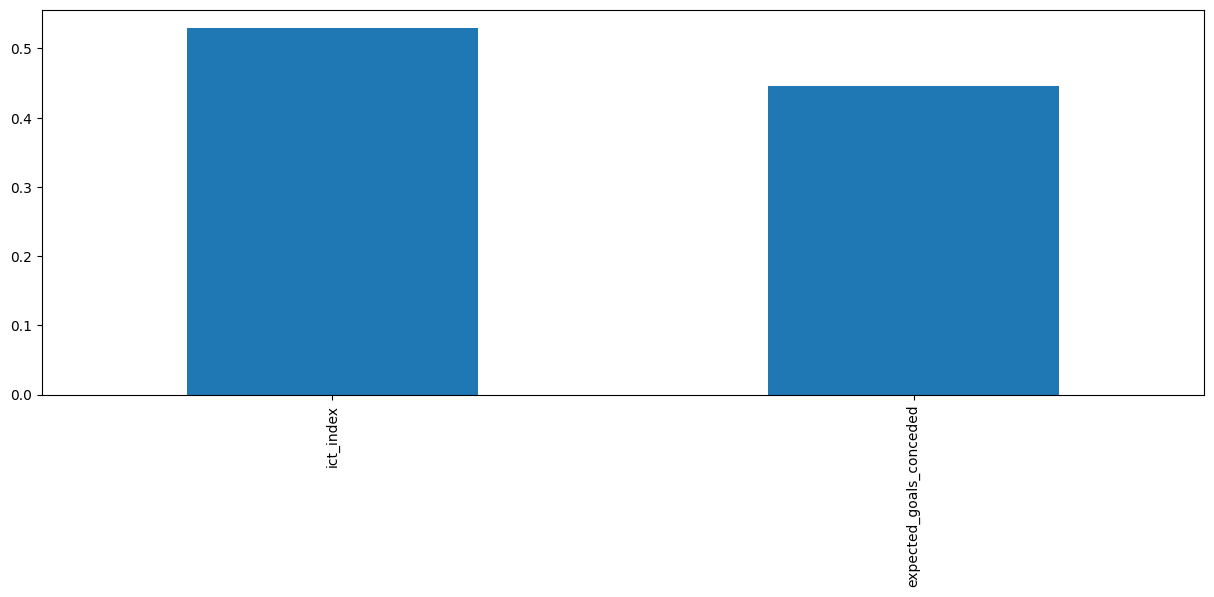

In [65]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

##### Select to 20% perct

In [66]:
from sklearn.feature_selection import SelectPercentile

## Selecting the top 20 percentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=50)
selected_top_columns.fit(k_sel_X_train, gk_splits['target_train'])

selected_top_columns.get_support()

array([ True, False])

In [68]:
gk_20_columns = k_sel_X_train.columns[selected_top_columns.get_support()]

gk_20_train = k_sel_X_train[gk_20_columns]
gk_20_test = k_sel_X_test[gk_20_columns]


In [69]:
gk_20_train.shape, gk_20_test.shape

((2410, 1), (603, 1))

##### Model (MI)

###### Linear Model

In [70]:

MI_gk_lin_reg = Linear_regression(gk_20_train, gk_20_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(MI_gk_lin_reg =  [MI_gk_lin_reg['train_RMSE'], MI_gk_lin_reg['test_RMSE'], MI_gk_lin_reg['cv_rmse'], MI_gk_lin_reg['R2_train'], MI_gk_lin_reg['R2_test']])

gk_evaluation_stats

Training set RMSE: 1.2681645914583028
Test set RMSE: 1.3012838262171895
Training set R2: 0.5511678570289043
Test set R2: 0.4948547053713751
count    10.000000
mean      1.265201
std       0.155781
min       1.019440
25%       1.159487
50%       1.237261
75%       1.380274
max       1.532505
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg,MI_gk_lin_reg
train_RMSE,1.161926,0.035196,0.757658,0.892989,1.166336,0.035196,0.759153,0.892989,1.232308,0.117008,0.836169,0.961547,1.268165
test_RMSE,1.235357,1.495157,1.152307,1.175463,1.241539,1.410694,1.154696,1.175463,1.286200,1.432425,1.136594,1.123488,1.301284
cv_rmse,1.188035,1.507652,1.129481,1.107850,1.191555,1.509706,1.134954,1.107850,1.233383,1.501838,1.151050,1.121890,1.265201
R2_train,0.623218,0.999654,0.839794,0.777451,0.620353,0.999654,0.839161,0.777451,0.576190,0.996179,0.804871,0.741968,0.551168
R2_test,0.544742,0.333122,0.603897,0.587817,0.540174,0.406340,0.602252,0.587817,0.506497,0.387909,0.614626,0.623462,0.494855


###### DecisionTree Model

In [71]:
MI_gk_dt_reg = DecisionTreeRegression(gk_20_train, gk_20_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(MI_gk_dt_reg = [MI_gk_dt_reg['train_RMSE'], MI_gk_dt_reg['test_RMSE'], MI_gk_dt_reg['cv_rmse'], MI_gk_dt_reg['R2_train'], MI_gk_dt_reg['R2_test']])

gk_evaluation_stats



Training set RMSE: 1.085435638396332
Test set RMSE: 1.3113914650715315
Training set R2: 0.6711931483893032
Test set R2: 0.48697686090272607
count    10.000000
mean      1.255214
std       0.209118
min       0.957230
25%       1.090364
50%       1.256072
75%       1.368092
max       1.596912
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg,MI_gk_lin_reg,MI_gk_dt_reg
train_RMSE,1.161926,0.035196,0.757658,0.892989,1.166336,0.035196,0.759153,0.892989,1.232308,0.117008,0.836169,0.961547,1.268165,1.085436
test_RMSE,1.235357,1.495157,1.152307,1.175463,1.241539,1.410694,1.154696,1.175463,1.286200,1.432425,1.136594,1.123488,1.301284,1.311391
cv_rmse,1.188035,1.507652,1.129481,1.107850,1.191555,1.509706,1.134954,1.107850,1.233383,1.501838,1.151050,1.121890,1.265201,1.255214
R2_train,0.623218,0.999654,0.839794,0.777451,0.620353,0.999654,0.839161,0.777451,0.576190,0.996179,0.804871,0.741968,0.551168,0.671193
R2_test,0.544742,0.333122,0.603897,0.587817,0.540174,0.406340,0.602252,0.587817,0.506497,0.387909,0.614626,0.623462,0.494855,0.486977


###### RandomForest Model

In [72]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
MI_gk_rf_reg = RandomForestRegression(gk_20_train, gk_20_test,
                               gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(MI_gk_rf_reg = [MI_gk_rf_reg['train_RMSE'], MI_gk_rf_reg['test_RMSE'], MI_gk_rf_reg['cv_rmse'], MI_gk_rf_reg['R2_train'], MI_gk_rf_reg['R2_test']])

gk_evaluation_stats

count    10.000000
mean      1.215899
std       0.185834
min       0.919194
25%       1.065564
50%       1.224945
75%       1.322497
max       1.483687
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg,MI_gk_lin_reg,MI_gk_dt_reg,MI_gk_rf_reg
train_RMSE,1.161926,0.035196,0.757658,0.892989,1.166336,0.035196,0.759153,0.892989,1.232308,0.117008,0.836169,0.961547,1.268165,1.085436,1.097823
test_RMSE,1.235357,1.495157,1.152307,1.175463,1.241539,1.410694,1.154696,1.175463,1.286200,1.432425,1.136594,1.123488,1.301284,1.311391,1.313343
cv_rmse,1.188035,1.507652,1.129481,1.107850,1.191555,1.509706,1.134954,1.107850,1.233383,1.501838,1.151050,1.121890,1.265201,1.255214,1.215899
R2_train,0.623218,0.999654,0.839794,0.777451,0.620353,0.999654,0.839161,0.777451,0.576190,0.996179,0.804871,0.741968,0.551168,0.671193,0.663645
R2_test,0.544742,0.333122,0.603897,0.587817,0.540174,0.406340,0.602252,0.587817,0.506497,0.387909,0.614626,0.623462,0.494855,0.486977,0.485449


###### XgBoost Model

In [73]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
MI_gk_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(MI_gk_xgb_reg = [MI_gk_xgb_reg['train_RMSE'], MI_gk_xgb_reg['test_RMSE'], MI_gk_xgb_reg['cv_rmse'], MI_gk_xgb_reg['R2_train'], MI_gk_xgb_reg['R2_test']])
gk_evaluation_stats

,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg,MI_gk_lin_reg,MI_gk_dt_reg,MI_gk_rf_reg,MI_gk_xgb_reg
train_RMSE,1.161926,0.035196,0.757658,0.892989,1.166336,0.035196,0.759153,0.892989,1.232308,0.117008,0.836169,0.961547,1.268165,1.085436,1.097823,0.961547
test_RMSE,1.235357,1.495157,1.152307,1.175463,1.241539,1.410694,1.154696,1.175463,1.286200,1.432425,1.136594,1.123488,1.301284,1.311391,1.313343,1.123488
cv_rmse,1.188035,1.507652,1.129481,1.107850,1.191555,1.509706,1.134954,1.107850,1.233383,1.501838,1.151050,1.121890,1.265201,1.255214,1.215899,1.121890
R2_train,0.623218,0.999654,0.839794,0.777451,0.620353,0.999654,0.839161,0.777451,0.576190,0.996179,0.804871,0.741968,0.551168,0.671193,0.663645,0.741968
R2_test,0.544742,0.333122,0.603897,0.587817,0.540174,0.406340,0.602252,0.587817,0.506497,0.387909,0.614626,0.623462,0.494855,0.486977,0.485449,0.623462


## Defenders


### VarianceThreshold

In [74]:
VT_scaler = StandardScaler()
df_def_train_scaled = pd.DataFrame(VT_scaler.fit_transform(def_splits['feature_train']), columns=def_splits['feature_train'].columns)
df_def_test_scaled = pd.DataFrame(VT_scaler.transform(def_splits['features_test']), columns=def_splits['features_test'].columns)

selector = VarianceThreshold(threshold = 0.1)
selector.fit_transform(df_def_train_scaled)

def_threshold_columns = df_def_train_scaled.columns[selector.get_support()]

def_threshold_train = df_def_train_scaled[def_threshold_columns]
def_threshold_test = df_def_test_scaled[def_threshold_columns]

def_threshold_train.shape, def_threshold_test.shape

((6789, 21), (1698, 21))

#### Model(VT)

##### Linear Model

In [75]:

VarT_def_lin_reg = Linear_regression(def_threshold_train, def_threshold_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(VarT_def_lin_reg =  [VarT_def_lin_reg['train_RMSE'], VarT_def_lin_reg['test_RMSE'], VarT_def_lin_reg['cv_rmse'], VarT_def_lin_reg['R2_train'], VarT_def_lin_reg['R2_test']])

def_evaluation_stats

Training set RMSE: 1.528128882280786
Test set RMSE: 1.5479616464847772
Training set R2: 0.5252982931789404
Test set R2: 0.5217786033209777
count    10.000000
mean      1.536999
std       0.114866
min       1.320909
25%       1.512811
50%       1.559846
75%       1.602283
max       1.714118
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg
train_RMSE,1.528129,0.031296,1.144598,1.338167,1.528129
test_RMSE,1.547962,2.110464,1.520657,1.504497,1.547962
cv_rmse,1.536999,2.115961,1.486946,1.476898,1.536999
R2_train,0.525298,0.999801,0.733678,0.635983,0.525298
R2_test,0.521779,0.111076,0.538500,0.548257,0.521779


##### DecisionTree Model

In [76]:
VarT_def_dt_reg = DecisionTreeRegression(def_threshold_train, def_threshold_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(VarT_def_dt_reg = [VarT_def_dt_reg['train_RMSE'], VarT_def_dt_reg['test_RMSE'], VarT_def_dt_reg['cv_rmse'], VarT_def_dt_reg['R2_train'], VarT_def_dt_reg['R2_test']])

def_evaluation_stats



Training set RMSE: 0.03129588469419177
Test set RMSE: 2.0600512804175195
Training set R2: 0.9998008981520281
Test set R2: 0.15303654048827064
count    10.000000
mean      2.126267
std       0.122552
min       1.902250
25%       2.056578
50%       2.149928
75%       2.219023
max       2.280157
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg
train_RMSE,1.528129,0.031296,1.144598,1.338167,1.528129,0.031296
test_RMSE,1.547962,2.110464,1.520657,1.504497,1.547962,2.060051
cv_rmse,1.536999,2.115961,1.486946,1.476898,1.536999,2.126267
R2_train,0.525298,0.999801,0.733678,0.635983,0.525298,0.999801
R2_test,0.521779,0.111076,0.538500,0.548257,0.521779,0.153037


##### RandomForest Model

In [77]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
VarT_def_rf_reg = RandomForestRegression(def_threshold_train, def_threshold_test,
                               def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(VarT_def_rf_reg = [VarT_def_rf_reg['train_RMSE'], VarT_def_rf_reg['test_RMSE'], VarT_def_rf_reg['cv_rmse'], VarT_def_rf_reg['R2_train'], VarT_def_rf_reg['R2_test']])

def_evaluation_stats

count    10.000000
mean      1.487599
std       0.133882
min       1.256761
25%       1.409645
50%       1.484836
75%       1.570394
max       1.700864
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg
train_RMSE,1.528129,0.031296,1.144598,1.338167,1.528129,0.031296,1.144095
test_RMSE,1.547962,2.110464,1.520657,1.504497,1.547962,2.060051,1.524286
cv_rmse,1.536999,2.115961,1.486946,1.476898,1.536999,2.126267,1.487599
R2_train,0.525298,0.999801,0.733678,0.635983,0.525298,0.999801,0.733912
R2_test,0.521779,0.111076,0.538500,0.548257,0.521779,0.153037,0.536295


##### XgBoost Model

In [78]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
VarT_def_xgb_reg = XGBoostRegression(def_threshold_train, def_threshold_test, def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(VarT_def_xgb_reg = [VarT_def_xgb_reg['train_RMSE'], VarT_def_xgb_reg['test_RMSE'], VarT_def_xgb_reg['cv_rmse'], VarT_def_xgb_reg['R2_train'], VarT_def_xgb_reg['R2_test']])
def_evaluation_stats

,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg
train_RMSE,1.528129,0.031296,1.144598,1.338167,1.528129,0.031296,1.144095,1.338167
test_RMSE,1.547962,2.110464,1.520657,1.504497,1.547962,2.060051,1.524286,1.504497
cv_rmse,1.536999,2.115961,1.486946,1.476898,1.536999,2.126267,1.487599,1.476898
R2_train,0.525298,0.999801,0.733678,0.635983,0.525298,0.999801,0.733912,0.635983
R2_test,0.521779,0.111076,0.538500,0.548257,0.521779,0.153037,0.536295,0.548257


### Feature selection techniques

#### K-best features

In [79]:

from sklearn.feature_selection import SelectKBest, mutual_info_regression

k_rf_model = RandomForestRegressor(n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18)

score_list  = []

for k in range(1, 21):
  selector = SelectKBest(mutual_info_regression, k=k)
  k_sel_X_train =  selector.fit_transform(def_threshold_train, def_splits['target_train'])

  k_rf_model.fit(k_sel_X_train, def_splits['target_train'])

  k_sel_cols = def_threshold_train.columns[selector.get_support()]
  k_sel_X_test = def_threshold_test[k_sel_cols]
  score = round(k_rf_model.score(k_sel_X_test.values, def_splits['target_test'] ), 3)

  score_list.append(score)
print(score_list, score_list.index(max(score_list)))
num_of_feat = score_list.index(max(score_list)) # find the highest score. We will use  that as the value of k

[0.347, 0.539, 0.535, 0.541, 0.553, 0.551, 0.539, 0.524, 0.534, 0.524, 0.537, 0.521, 0.512, 0.518, 0.517, 0.535, 0.524, 0.528, 0.522, 0.518] 4


In [94]:
selector = SelectKBest(mutual_info_regression, k=num_of_feat+1)
selector.fit_transform(def_threshold_train, def_splits['target_train'])

sel_feats = selector.get_feature_names_out()
k_sel_X_train = def_threshold_train[sel_feats]
k_sel_X_test = def_threshold_test[sel_feats]

##### Model (KBest)

###### Linear Model

In [95]:

KBest_def_lin_reg = Linear_regression(k_sel_X_train, k_sel_X_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(KBest_def_lin_reg =  [KBest_def_lin_reg['train_RMSE'], KBest_def_lin_reg['test_RMSE'], KBest_def_lin_reg['cv_rmse'], KBest_def_lin_reg['R2_train'], KBest_def_lin_reg['R2_test']])

def_evaluation_stats

Training set RMSE: 1.537975554039788
Test set RMSE: 1.550028943134567
Training set R2: 0.5191609949228495
Test set R2: 0.5205004248258278
count    10.000000
mean      1.538774
std       0.116734
min       1.315773
25%       1.519340
50%       1.548146
75%       1.609442
max       1.716099
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg,MI_def_xgb_reg
train_RMSE,1.528129,0.031296,1.144598,1.338167,1.528129,0.031296,1.144095,1.338167,1.537976,0.141152,1.203969,1.358701,1.561224,0.332285,1.266506,1.358701
test_RMSE,1.547962,2.110464,1.520657,1.504497,1.547962,2.060051,1.524286,1.504497,1.550029,2.001723,1.492873,1.494185,1.561262,2.075431,1.546156,1.494185
cv_rmse,1.536999,2.115961,1.486946,1.476898,1.536999,2.126267,1.487599,1.476898,1.538774,2.063917,1.479135,1.470455,1.559501,2.043348,1.506043,1.470455
R2_train,0.525298,0.999801,0.733678,0.635983,0.525298,0.999801,0.733912,0.635983,0.519161,0.995950,0.705333,0.624726,0.504514,0.977555,0.673927,0.624726
R2_test,0.521779,0.111076,0.538500,0.548257,0.521779,0.153037,0.536295,0.548257,0.520500,0.200319,0.555211,0.554428,0.513525,0.140343,0.522894,0.554428


###### DecisionTree Model

In [96]:
KBest_def_dt_reg = DecisionTreeRegression(k_sel_X_train, k_sel_X_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(KBest_def_dt_reg = [KBest_def_dt_reg['train_RMSE'], KBest_def_dt_reg['test_RMSE'], KBest_def_dt_reg['cv_rmse'], KBest_def_dt_reg['R2_train'], KBest_def_dt_reg['R2_test']])

def_evaluation_stats



Training set RMSE: 0.052255462127766404
Test set RMSE: 2.108375545746627
Training set R2: 0.9994449089684481
Test set R2: 0.11283468910565608
count    10.000000
mean      2.070915
std       0.138063
min       1.870714
25%       1.941078
50%       2.096424
75%       2.159536
max       2.260732
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg,MI_def_xgb_reg
train_RMSE,1.528129,0.031296,1.144598,1.338167,1.528129,0.031296,1.144095,1.338167,1.537976,0.052255,1.203969,1.358701,1.561224,0.332285,1.266506,1.358701
test_RMSE,1.547962,2.110464,1.520657,1.504497,1.547962,2.060051,1.524286,1.504497,1.550029,2.108376,1.492873,1.494185,1.561262,2.075431,1.546156,1.494185
cv_rmse,1.536999,2.115961,1.486946,1.476898,1.536999,2.126267,1.487599,1.476898,1.538774,2.070915,1.479135,1.470455,1.559501,2.043348,1.506043,1.470455
R2_train,0.525298,0.999801,0.733678,0.635983,0.525298,0.999801,0.733912,0.635983,0.519161,0.999445,0.705333,0.624726,0.504514,0.977555,0.673927,0.624726
R2_test,0.521779,0.111076,0.538500,0.548257,0.521779,0.153037,0.536295,0.548257,0.520500,0.112835,0.555211,0.554428,0.513525,0.140343,0.522894,0.554428


###### RandomForest Model

In [97]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
KBest_def_rf_reg = RandomForestRegression(k_sel_X_train, k_sel_X_test,
                               def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(KBest_def_rf_reg = [KBest_def_rf_reg['train_RMSE'], KBest_def_rf_reg['test_RMSE'], KBest_def_rf_reg['cv_rmse'], KBest_def_rf_reg['R2_train'], KBest_def_rf_reg['R2_test']])

def_evaluation_stats

count    10.000000
mean      1.484410
std       0.124433
min       1.265559
25%       1.414949
50%       1.513481
75%       1.566795
max       1.666452
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg,MI_def_xgb_reg
train_RMSE,1.528129,0.031296,1.144598,1.338167,1.528129,0.031296,1.144095,1.338167,1.537976,0.052255,1.187744,1.358701,1.561224,0.332285,1.266506,1.358701
test_RMSE,1.547962,2.110464,1.520657,1.504497,1.547962,2.060051,1.524286,1.504497,1.550029,2.108376,1.496682,1.494185,1.561262,2.075431,1.546156,1.494185
cv_rmse,1.536999,2.115961,1.486946,1.476898,1.536999,2.126267,1.487599,1.476898,1.538774,2.070915,1.484410,1.470455,1.559501,2.043348,1.506043,1.470455
R2_train,0.525298,0.999801,0.733678,0.635983,0.525298,0.999801,0.733912,0.635983,0.519161,0.999445,0.713221,0.624726,0.504514,0.977555,0.673927,0.624726
R2_test,0.521779,0.111076,0.538500,0.548257,0.521779,0.153037,0.536295,0.548257,0.520500,0.112835,0.552938,0.554428,0.513525,0.140343,0.522894,0.554428


###### XgBoost Model

In [98]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
KBest_def_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(KBest_def_xgb_reg = [KBest_def_xgb_reg['train_RMSE'], KBest_def_xgb_reg['test_RMSE'], KBest_def_xgb_reg['cv_rmse'], KBest_def_xgb_reg['R2_train'], KBest_def_xgb_reg['R2_test']])
def_evaluation_stats

,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg,MI_def_xgb_reg
train_RMSE,1.528129,0.031296,1.144598,1.338167,1.528129,0.031296,1.144095,1.338167,1.537976,0.052255,1.187744,1.354777,1.561224,0.332285,1.266506,1.358701
test_RMSE,1.547962,2.110464,1.520657,1.504497,1.547962,2.060051,1.524286,1.504497,1.550029,2.108376,1.496682,1.494898,1.561262,2.075431,1.546156,1.494185
cv_rmse,1.536999,2.115961,1.486946,1.476898,1.536999,2.126267,1.487599,1.476898,1.538774,2.070915,1.484410,1.472449,1.559501,2.043348,1.506043,1.470455
R2_train,0.525298,0.999801,0.733678,0.635983,0.525298,0.999801,0.733912,0.635983,0.519161,0.999445,0.713221,0.626890,0.504514,0.977555,0.673927,0.624726
R2_test,0.521779,0.111076,0.538500,0.548257,0.521779,0.153037,0.536295,0.548257,0.520500,0.112835,0.552938,0.554003,0.513525,0.140343,0.522894,0.554428


#### Mutual Information

In [99]:
from sklearn.feature_selection import mutual_info_regression
# def_sel_X_train
mutual_info = mutual_info_regression(k_sel_X_train, def_splits['target_train'])
mutual_info

array([0.5358521 , 0.27654814, 0.32725812, 0.54233062, 0.21670296])

In [100]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = k_sel_X_train.columns
mutual_info.sort_values(ascending=False)

,0
expected_goals_conceded,0.542331
ict_index,0.535852
expected_goal_involvements,0.327258
expected_assists,0.276548
bps_3,0.216703


<Axes: >

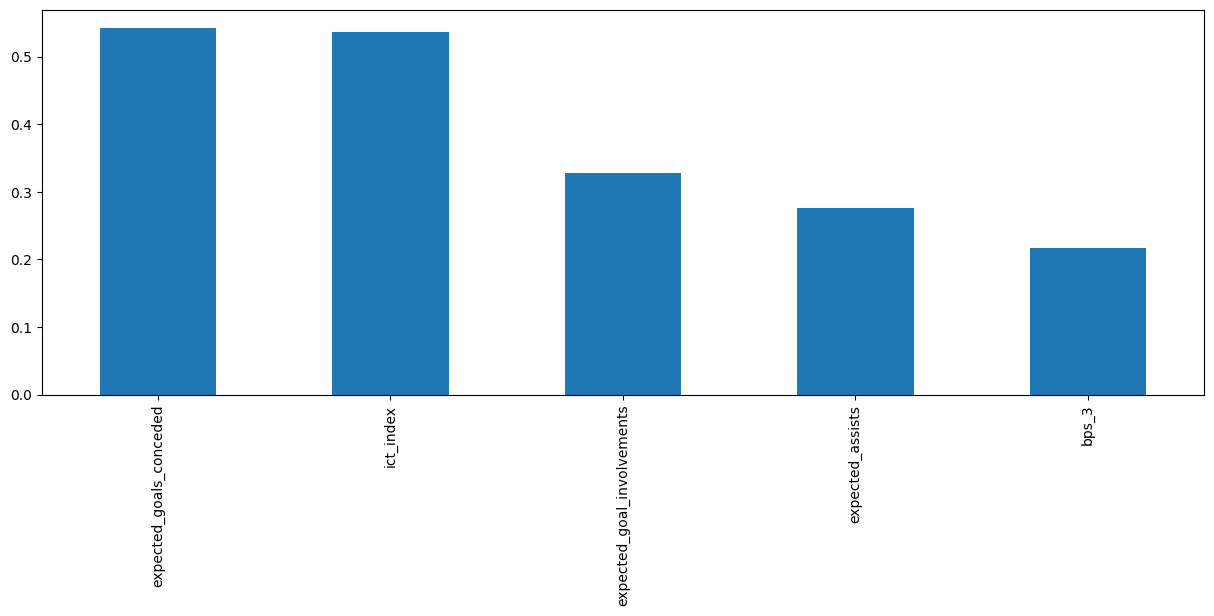

In [101]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

##### Select to 20% perct

In [102]:
from sklearn.feature_selection import SelectPercentile

## Selecting the top 20 percentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=50)
selected_top_columns.fit(k_sel_X_train, def_splits['target_train'])

selected_top_columns.get_support()

array([ True, False, False,  True, False])

In [103]:
def_20_columns = k_sel_X_train.columns[selected_top_columns.get_support()]

def_20_train = k_sel_X_train[def_20_columns]
def_20_test = k_sel_X_test[def_20_columns]


##### Model (MI)

###### Linear Model

In [104]:

MI_def_lin_reg = Linear_regression(def_20_train, def_20_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(MI_def_lin_reg =  [MI_def_lin_reg['train_RMSE'], MI_def_lin_reg['test_RMSE'], MI_def_lin_reg['cv_rmse'], MI_def_lin_reg['R2_train'], MI_def_lin_reg['R2_test']])

def_evaluation_stats

Training set RMSE: 1.5612236593610755
Test set RMSE: 1.5612624242516684
Training set R2: 0.5045143591252028
Test set R2: 0.5135251125531837
count    10.000000
mean      1.559501
std       0.118783
min       1.339105
25%       1.525165
50%       1.585503
75%       1.612127
max       1.744543
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg,MI_def_xgb_reg
train_RMSE,1.528129,0.031296,1.144598,1.338167,1.528129,0.031296,1.144095,1.338167,1.537976,0.052255,1.187744,1.354777,1.561224,0.332285,1.266506,1.358701
test_RMSE,1.547962,2.110464,1.520657,1.504497,1.547962,2.060051,1.524286,1.504497,1.550029,2.108376,1.496682,1.494898,1.561262,2.075431,1.546156,1.494185
cv_rmse,1.536999,2.115961,1.486946,1.476898,1.536999,2.126267,1.487599,1.476898,1.538774,2.070915,1.484410,1.472449,1.559501,2.043348,1.506043,1.470455
R2_train,0.525298,0.999801,0.733678,0.635983,0.525298,0.999801,0.733912,0.635983,0.519161,0.999445,0.713221,0.626890,0.504514,0.977555,0.673927,0.624726
R2_test,0.521779,0.111076,0.538500,0.548257,0.521779,0.153037,0.536295,0.548257,0.520500,0.112835,0.552938,0.554003,0.513525,0.140343,0.522894,0.554428


###### DecisionTree Model

In [105]:
MI_def_dt_reg = DecisionTreeRegression(def_20_train, def_20_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(MI_def_dt_reg = [MI_def_dt_reg['train_RMSE'], MI_def_dt_reg['test_RMSE'], MI_def_dt_reg['cv_rmse'], MI_def_dt_reg['R2_train'], MI_def_dt_reg['R2_test']])

def_evaluation_stats



Training set RMSE: 0.33228509955552177
Test set RMSE: 2.0414921532023222
Training set R2: 0.9775548475865977
Test set R2: 0.16822848883048092
count    10.000000
mean      2.041158
std       0.142870
min       1.876331
25%       1.942213
50%       1.963338
75%       2.175791
max       2.266128
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg,MI_def_xgb_reg
train_RMSE,1.528129,0.031296,1.144598,1.338167,1.528129,0.031296,1.144095,1.338167,1.537976,0.052255,1.187744,1.354777,1.561224,0.332285,1.266506,1.358701
test_RMSE,1.547962,2.110464,1.520657,1.504497,1.547962,2.060051,1.524286,1.504497,1.550029,2.108376,1.496682,1.494898,1.561262,2.041492,1.546156,1.494185
cv_rmse,1.536999,2.115961,1.486946,1.476898,1.536999,2.126267,1.487599,1.476898,1.538774,2.070915,1.484410,1.472449,1.559501,2.041158,1.506043,1.470455
R2_train,0.525298,0.999801,0.733678,0.635983,0.525298,0.999801,0.733912,0.635983,0.519161,0.999445,0.713221,0.626890,0.504514,0.977555,0.673927,0.624726
R2_test,0.521779,0.111076,0.538500,0.548257,0.521779,0.153037,0.536295,0.548257,0.520500,0.112835,0.552938,0.554003,0.513525,0.168228,0.522894,0.554428


###### RandomForest Model

In [106]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
MI_def_rf_reg = RandomForestRegression(def_20_train, def_20_test,
                               def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(MI_def_rf_reg = [MI_def_rf_reg['train_RMSE'], MI_def_rf_reg['test_RMSE'], MI_def_rf_reg['cv_rmse'], MI_def_rf_reg['R2_train'], MI_def_rf_reg['R2_test']])

def_evaluation_stats

count    10.000000
mean      1.506043
std       0.138960
min       1.255193
25%       1.435070
50%       1.531918
75%       1.586345
max       1.750909
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg,MI_def_xgb_reg
train_RMSE,1.528129,0.031296,1.144598,1.338167,1.528129,0.031296,1.144095,1.338167,1.537976,0.052255,1.187744,1.354777,1.561224,0.332285,1.266506,1.358701
test_RMSE,1.547962,2.110464,1.520657,1.504497,1.547962,2.060051,1.524286,1.504497,1.550029,2.108376,1.496682,1.494898,1.561262,2.041492,1.546156,1.494185
cv_rmse,1.536999,2.115961,1.486946,1.476898,1.536999,2.126267,1.487599,1.476898,1.538774,2.070915,1.484410,1.472449,1.559501,2.041158,1.506043,1.470455
R2_train,0.525298,0.999801,0.733678,0.635983,0.525298,0.999801,0.733912,0.635983,0.519161,0.999445,0.713221,0.626890,0.504514,0.977555,0.673927,0.624726
R2_test,0.521779,0.111076,0.538500,0.548257,0.521779,0.153037,0.536295,0.548257,0.520500,0.112835,0.552938,0.554003,0.513525,0.168228,0.522894,0.554428


###### XgBoost Model

In [107]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
MI_def_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(MI_def_xgb_reg = [MI_def_xgb_reg['train_RMSE'], MI_def_xgb_reg['test_RMSE'], MI_def_xgb_reg['cv_rmse'], MI_def_xgb_reg['R2_train'], MI_def_xgb_reg['R2_test']])
def_evaluation_stats

,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg,MI_def_xgb_reg
train_RMSE,1.528129,0.031296,1.144598,1.338167,1.528129,0.031296,1.144095,1.338167,1.537976,0.052255,1.187744,1.354777,1.561224,0.332285,1.266506,1.354777
test_RMSE,1.547962,2.110464,1.520657,1.504497,1.547962,2.060051,1.524286,1.504497,1.550029,2.108376,1.496682,1.494898,1.561262,2.041492,1.546156,1.494898
cv_rmse,1.536999,2.115961,1.486946,1.476898,1.536999,2.126267,1.487599,1.476898,1.538774,2.070915,1.484410,1.472449,1.559501,2.041158,1.506043,1.472449
R2_train,0.525298,0.999801,0.733678,0.635983,0.525298,0.999801,0.733912,0.635983,0.519161,0.999445,0.713221,0.626890,0.504514,0.977555,0.673927,0.626890
R2_test,0.521779,0.111076,0.538500,0.548257,0.521779,0.153037,0.536295,0.548257,0.520500,0.112835,0.552938,0.554003,0.513525,0.168228,0.522894,0.554003


## Midfielders


### VarianceThreshold

In [108]:
VT_scaler = StandardScaler()
df_mid_train_scaled = pd.DataFrame(VT_scaler.fit_transform(mid_splits['feature_train']), columns=mid_splits['feature_train'].columns)
df_mid_test_scaled = pd.DataFrame(VT_scaler.transform(mid_splits['features_test']), columns=mid_splits['features_test'].columns)

selector = VarianceThreshold(threshold = 0.1)
selector.fit_transform(df_mid_train_scaled)

mid_threshold_columns = df_mid_train_scaled.columns[selector.get_support()]

mid_threshold_train = df_mid_train_scaled[mid_threshold_columns]
mid_threshold_test = df_mid_test_scaled[mid_threshold_columns]

mid_threshold_train.shape, mid_threshold_test.shape

((9070, 22), (2268, 22))

#### Model(VT)

##### Linear Model

In [109]:

VarT_mid_lin_reg = Linear_regression(mid_threshold_train, mid_threshold_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(VarT_mid_lin_reg =  [VarT_mid_lin_reg['train_RMSE'], VarT_mid_lin_reg['test_RMSE'], VarT_mid_lin_reg['cv_rmse'], VarT_mid_lin_reg['R2_train'], VarT_mid_lin_reg['R2_test']])

mid_evaluation_stats

Training set RMSE: 1.2050721273400755
Test set RMSE: 1.2245862222207187
Training set R2: 0.7460383711395527
Test set R2: 0.7530775387749684
count    10.000000
mean      1.212407
std       0.076605
min       1.141759
25%       1.164514
50%       1.191550
75%       1.232213
max       1.400136
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg
train_RMSE,1.205072,0.044234,0.834991,1.021547,1.205072
test_RMSE,1.224586,1.614120,1.183569,1.201454,1.224586
cv_rmse,1.212407,1.599599,1.155467,1.153411,1.212407
R2_train,0.746038,0.999658,0.878071,0.817502,0.746038
R2_test,0.753078,0.571003,0.769342,0.762318,0.753078


##### DecisionTree Model

In [110]:
VarT_mid_dt_reg = DecisionTreeRegression(mid_threshold_train, mid_threshold_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(VarT_mid_dt_reg = [VarT_mid_dt_reg['train_RMSE'], VarT_mid_dt_reg['test_RMSE'], VarT_mid_dt_reg['cv_rmse'], VarT_mid_dt_reg['R2_train'], VarT_mid_dt_reg['R2_test']])

mid_evaluation_stats



Training set RMSE: 0.044234414801066546
Test set RMSE: 1.6237887971244023
Training set R2: 0.9996578137195443
Test set R2: 0.5658488647585973
count    10.000000
mean      1.610269
std       0.141126
min       1.452672
25%       1.509907
50%       1.587480
75%       1.636840
max       1.938414
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg
train_RMSE,1.205072,0.044234,0.834991,1.021547,1.205072,0.044234
test_RMSE,1.224586,1.614120,1.183569,1.201454,1.224586,1.623789
cv_rmse,1.212407,1.599599,1.155467,1.153411,1.212407,1.610269
R2_train,0.746038,0.999658,0.878071,0.817502,0.746038,0.999658
R2_test,0.753078,0.571003,0.769342,0.762318,0.753078,0.565849


##### RandomForest Model

In [111]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
VarT_mid_rf_reg = RandomForestRegression(mid_threshold_train, mid_threshold_test,
                               mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(VarT_mid_rf_reg = [VarT_mid_rf_reg['train_RMSE'], VarT_mid_rf_reg['test_RMSE'], VarT_mid_rf_reg['cv_rmse'], VarT_mid_rf_reg['R2_train'], VarT_mid_rf_reg['R2_test']])

mid_evaluation_stats

count    10.000000
mean      1.155957
std       0.092403
min       1.081118
25%       1.098506
50%       1.125050
75%       1.156640
max       1.380370
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg
train_RMSE,1.205072,0.044234,0.834991,1.021547,1.205072,0.044234,0.834061
test_RMSE,1.224586,1.614120,1.183569,1.201454,1.224586,1.623789,1.186505
cv_rmse,1.212407,1.599599,1.155467,1.153411,1.212407,1.610269,1.155957
R2_train,0.746038,0.999658,0.878071,0.817502,0.746038,0.999658,0.878343
R2_test,0.753078,0.571003,0.769342,0.762318,0.753078,0.565849,0.768196


##### XgBoost Model

In [112]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
VarT_mid_xgb_reg = XGBoostRegression(mid_threshold_train, mid_threshold_test, mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(VarT_mid_xgb_reg = [VarT_mid_xgb_reg['train_RMSE'], VarT_mid_xgb_reg['test_RMSE'], VarT_mid_xgb_reg['cv_rmse'], VarT_mid_xgb_reg['R2_train'], VarT_mid_xgb_reg['R2_test']])
mid_evaluation_stats

,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg
train_RMSE,1.205072,0.044234,0.834991,1.021547,1.205072,0.044234,0.834061,1.021547
test_RMSE,1.224586,1.614120,1.183569,1.201454,1.224586,1.623789,1.186505,1.201454
cv_rmse,1.212407,1.599599,1.155467,1.153411,1.212407,1.610269,1.155957,1.153411
R2_train,0.746038,0.999658,0.878071,0.817502,0.746038,0.999658,0.878343,0.817502
R2_test,0.753078,0.571003,0.769342,0.762318,0.753078,0.565849,0.768196,0.762318


### Feature selection techniques

#### K-best features

In [113]:

from sklearn.feature_selection import SelectKBest, mutual_info_regression

k_rf_model = RandomForestRegressor(n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18)

score_list  = []

for k in range(1, 21):
  selector = SelectKBest(mutual_info_regression, k=k)
  k_sel_X_train =  selector.fit_transform(mid_threshold_train, mid_splits['target_train'])

  k_rf_model.fit(k_sel_X_train, mid_splits['target_train'])

  k_sel_cols = mid_threshold_train.columns[selector.get_support()]
  k_sel_X_test = mid_threshold_test[k_sel_cols]
  score = round(k_rf_model.score(k_sel_X_test.values, mid_splits['target_test'] ), 3)

  score_list.append(score)
print(score_list, score_list.index(max(score_list)))
num_of_feat = score_list.index(max(score_list)) # find the highest score. We will use  that as the value of k

[0.719, 0.746, 0.755, 0.767, 0.767, 0.774, 0.764, 0.762, 0.76, 0.76, 0.753, 0.74, 0.755, 0.75, 0.745, 0.75, 0.766, 0.746, 0.753, 0.742] 5


In [114]:
selector = SelectKBest(mutual_info_regression, k=num_of_feat)
selector.fit_transform(mid_threshold_train, mid_splits['target_train'])

sel_feats = selector.get_feature_names_out()
k_sel_X_train = mid_threshold_train[sel_feats]
k_sel_X_test = mid_threshold_test[sel_feats]

##### Model (KBest)

###### Linear Model

In [115]:

KBest_mid_lin_reg = Linear_regression(k_sel_X_train, k_sel_X_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(KBest_mid_lin_reg =  [KBest_mid_lin_reg['train_RMSE'], KBest_mid_lin_reg['test_RMSE'], KBest_mid_lin_reg['cv_rmse'], KBest_mid_lin_reg['R2_train'], KBest_mid_lin_reg['R2_test']])

mid_evaluation_stats

Training set RMSE: 1.213122458807199
Test set RMSE: 1.2188294537503745
Training set R2: 0.7426339206097817
Test set R2: 0.7553936423571261
count    10.000000
mean      1.213660
std       0.076491
min       1.151505
25%       1.165790
50%       1.182997
75%       1.238880
max       1.404071
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg
train_RMSE,1.205072,0.044234,0.834991,1.021547,1.205072,0.044234,0.834061,1.021547,1.213122
test_RMSE,1.224586,1.614120,1.183569,1.201454,1.224586,1.623789,1.186505,1.201454,1.218829
cv_rmse,1.212407,1.599599,1.155467,1.153411,1.212407,1.610269,1.155957,1.153411,1.213660
R2_train,0.746038,0.999658,0.878071,0.817502,0.746038,0.999658,0.878343,0.817502,0.742634
R2_test,0.753078,0.571003,0.769342,0.762318,0.753078,0.565849,0.768196,0.762318,0.755394


###### DecisionTree Model

In [116]:
KBest_mid_dt_reg = DecisionTreeRegression(k_sel_X_train, k_sel_X_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(KBest_mid_dt_reg = [KBest_mid_dt_reg['train_RMSE'], KBest_mid_dt_reg['test_RMSE'], KBest_mid_dt_reg['cv_rmse'], KBest_mid_dt_reg['R2_train'], KBest_mid_dt_reg['R2_test']])

mid_evaluation_stats



Training set RMSE: 0.06574885526580068
Test set RMSE: 1.684806341950752
Training set R2: 0.999244005889038
Test set R2: 0.5326073951582346
count    10.000000
mean      1.624869
std       0.163176
min       1.464486
25%       1.535447
50%       1.562674
75%       1.693214
max       2.018759
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg
train_RMSE,1.205072,0.044234,0.834991,1.021547,1.205072,0.044234,0.834061,1.021547,1.213122,0.065749
test_RMSE,1.224586,1.614120,1.183569,1.201454,1.224586,1.623789,1.186505,1.201454,1.218829,1.684806
cv_rmse,1.212407,1.599599,1.155467,1.153411,1.212407,1.610269,1.155957,1.153411,1.213660,1.624869
R2_train,0.746038,0.999658,0.878071,0.817502,0.746038,0.999658,0.878343,0.817502,0.742634,0.999244
R2_test,0.753078,0.571003,0.769342,0.762318,0.753078,0.565849,0.768196,0.762318,0.755394,0.532607


###### RandomForest Model

In [117]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
KBest_mid_rf_reg = RandomForestRegression(k_sel_X_train, k_sel_X_test,
                               mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(KBest_mid_rf_reg = [KBest_mid_rf_reg['train_RMSE'], KBest_mid_rf_reg['test_RMSE'], KBest_mid_rf_reg['cv_rmse'], KBest_mid_rf_reg['R2_train'], KBest_mid_rf_reg['R2_test']])

mid_evaluation_stats

count    10.000000
mean      1.163703
std       0.099792
min       1.064515
25%       1.119108
50%       1.141648
75%       1.148222
max       1.426174
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg
train_RMSE,1.205072,0.044234,0.834991,1.021547,1.205072,0.044234,0.834061,1.021547,1.213122,0.065749,0.868323
test_RMSE,1.224586,1.614120,1.183569,1.201454,1.224586,1.623789,1.186505,1.201454,1.218829,1.684806,1.208846
cv_rmse,1.212407,1.599599,1.155467,1.153411,1.212407,1.610269,1.155957,1.153411,1.213660,1.624869,1.163703
R2_train,0.746038,0.999658,0.878071,0.817502,0.746038,0.999658,0.878343,0.817502,0.742634,0.999244,0.868143
R2_test,0.753078,0.571003,0.769342,0.762318,0.753078,0.565849,0.768196,0.762318,0.755394,0.532607,0.759384


###### XgBoost Model

In [118]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
KBest_mid_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(KBest_mid_xgb_reg = [KBest_mid_xgb_reg['train_RMSE'], KBest_mid_xgb_reg['test_RMSE'], KBest_mid_xgb_reg['cv_rmse'], KBest_mid_xgb_reg['R2_train'], KBest_mid_xgb_reg['R2_test']])
mid_evaluation_stats

,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg
train_RMSE,1.205072,0.044234,0.834991,1.021547,1.205072,0.044234,0.834061,1.021547,1.213122,0.065749,0.868323,1.046002
test_RMSE,1.224586,1.614120,1.183569,1.201454,1.224586,1.623789,1.186505,1.201454,1.218829,1.684806,1.208846,1.214833
cv_rmse,1.212407,1.599599,1.155467,1.153411,1.212407,1.610269,1.155957,1.153411,1.213660,1.624869,1.163703,1.156576
R2_train,0.746038,0.999658,0.878071,0.817502,0.746038,0.999658,0.878343,0.817502,0.742634,0.999244,0.868143,0.808659
R2_test,0.753078,0.571003,0.769342,0.762318,0.753078,0.565849,0.768196,0.762318,0.755394,0.532607,0.759384,0.756995


#### Mutual Information

In [119]:
from sklearn.feature_selection import mutual_info_regression
# def_sel_X_train
mutual_info = mutual_info_regression(k_sel_X_train, mid_splits['target_train'])
mutual_info

array([0.72925191, 0.43358473, 0.53392783, 0.61960594, 0.33454318])

In [120]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = k_sel_X_train.columns
mutual_info.sort_values(ascending=False)

,0
ict_index,0.729252
expected_goals_conceded,0.619606
expected_goal_involvements,0.533928
expected_assists,0.433585
minutes_3,0.334543


<Axes: >

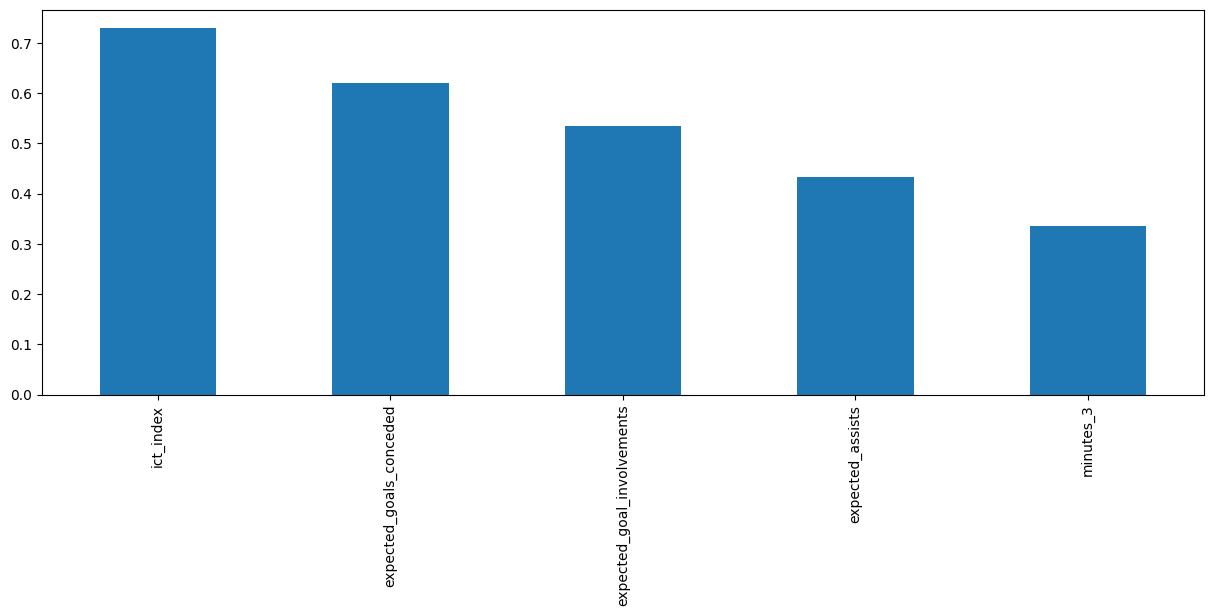

In [121]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

##### Select to 20% perct

In [122]:
from sklearn.feature_selection import SelectPercentile

## Selecting the top 20 percentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=50)
selected_top_columns.fit(k_sel_X_train, mid_splits['target_train'])

selected_top_columns.get_support()

array([ True, False, False,  True, False])

In [123]:
mid_20_columns = k_sel_X_train.columns[selected_top_columns.get_support()]

mid_20_train = k_sel_X_train[mid_20_columns]
mid_20_test = k_sel_X_test[mid_20_columns]


##### Model (MI)

###### Linear Model

In [124]:

MI_mid_lin_reg = Linear_regression(mid_20_train, mid_20_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(MI_mid_lin_reg =  [MI_mid_lin_reg['train_RMSE'], MI_mid_lin_reg['test_RMSE'], MI_mid_lin_reg['cv_rmse'], MI_mid_lin_reg['R2_train'], MI_mid_lin_reg['R2_test']])

mid_evaluation_stats

Training set RMSE: 1.25047847108807
Test set RMSE: 1.2449948531353205
Training set R2: 0.7265395910660463
Test set R2: 0.7447786676671913
count    10.000000
mean      1.248435
std       0.091598
min       1.153146
25%       1.182761
50%       1.225741
75%       1.290123
max       1.454972
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg,MI_mid_lin_reg
train_RMSE,1.205072,0.044234,0.834991,1.021547,1.205072,0.044234,0.834061,1.021547,1.213122,0.065749,0.868323,1.046002,1.250478
test_RMSE,1.224586,1.614120,1.183569,1.201454,1.224586,1.623789,1.186505,1.201454,1.218829,1.684806,1.208846,1.214833,1.244995
cv_rmse,1.212407,1.599599,1.155467,1.153411,1.212407,1.610269,1.155957,1.153411,1.213660,1.624869,1.163703,1.156576,1.248435
R2_train,0.746038,0.999658,0.878071,0.817502,0.746038,0.999658,0.878343,0.817502,0.742634,0.999244,0.868143,0.808659,0.726540
R2_test,0.753078,0.571003,0.769342,0.762318,0.753078,0.565849,0.768196,0.762318,0.755394,0.532607,0.759384,0.756995,0.744779


###### DecisionTree Model

In [125]:
MI_mid_dt_reg = DecisionTreeRegression(mid_20_train, mid_20_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(MI_mid_dt_reg = [MI_mid_dt_reg['train_RMSE'], MI_mid_dt_reg['test_RMSE'], MI_mid_dt_reg['cv_rmse'], MI_mid_dt_reg['R2_train'], MI_mid_dt_reg['R2_test']])

mid_evaluation_stats



Training set RMSE: 0.2263829235538444
Test set RMSE: 1.6527369678470134
Training set R2: 0.9910374962762695
Test set R2: 0.550231182890589
count    10.000000
mean      1.685087
std       0.078874
min       1.571190
25%       1.643730
50%       1.663372
75%       1.744952
max       1.806144
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg,MI_mid_lin_reg,MI_mid_dt_reg
train_RMSE,1.205072,0.044234,0.834991,1.021547,1.205072,0.044234,0.834061,1.021547,1.213122,0.065749,0.868323,1.046002,1.250478,0.226383
test_RMSE,1.224586,1.614120,1.183569,1.201454,1.224586,1.623789,1.186505,1.201454,1.218829,1.684806,1.208846,1.214833,1.244995,1.652737
cv_rmse,1.212407,1.599599,1.155467,1.153411,1.212407,1.610269,1.155957,1.153411,1.213660,1.624869,1.163703,1.156576,1.248435,1.685087
R2_train,0.746038,0.999658,0.878071,0.817502,0.746038,0.999658,0.878343,0.817502,0.742634,0.999244,0.868143,0.808659,0.726540,0.991037
R2_test,0.753078,0.571003,0.769342,0.762318,0.753078,0.565849,0.768196,0.762318,0.755394,0.532607,0.759384,0.756995,0.744779,0.550231


###### RandomForest Model

In [126]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
MI_mid_rf_reg = RandomForestRegression(mid_20_train, mid_20_test,
                               mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(MI_mid_rf_reg = [MI_mid_rf_reg['train_RMSE'], MI_mid_rf_reg['test_RMSE'], MI_mid_rf_reg['cv_rmse'], MI_mid_rf_reg['R2_train'], MI_mid_rf_reg['R2_test']])

mid_evaluation_stats

count    10.000000
mean      1.261543
std       0.094620
min       1.161087
25%       1.192273
50%       1.251979
75%       1.286342
max       1.477075
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg,MI_mid_lin_reg,MI_mid_dt_reg,MI_mid_rf_reg
train_RMSE,1.205072,0.044234,0.834991,1.021547,1.205072,0.044234,0.834061,1.021547,1.213122,0.065749,0.868323,1.046002,1.250478,0.226383,1.009431
test_RMSE,1.224586,1.614120,1.183569,1.201454,1.224586,1.623789,1.186505,1.201454,1.218829,1.684806,1.208846,1.214833,1.244995,1.652737,1.261288
cv_rmse,1.212407,1.599599,1.155467,1.153411,1.212407,1.610269,1.155957,1.153411,1.213660,1.624869,1.163703,1.156576,1.248435,1.685087,1.261543
R2_train,0.746038,0.999658,0.878071,0.817502,0.746038,0.999658,0.878343,0.817502,0.742634,0.999244,0.868143,0.808659,0.726540,0.991037,0.821805
R2_test,0.753078,0.571003,0.769342,0.762318,0.753078,0.565849,0.768196,0.762318,0.755394,0.532607,0.759384,0.756995,0.744779,0.550231,0.738055


###### XgBoost Model

In [127]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
MI_mid_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(MI_mid_xgb_reg = [MI_mid_xgb_reg['train_RMSE'], MI_mid_xgb_reg['test_RMSE'], MI_mid_xgb_reg['cv_rmse'], MI_mid_xgb_reg['R2_train'], MI_mid_xgb_reg['R2_test']])
mid_evaluation_stats

,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg,MI_mid_lin_reg,MI_mid_dt_reg,MI_mid_rf_reg,MI_mid_xgb_reg
train_RMSE,1.205072,0.044234,0.834991,1.021547,1.205072,0.044234,0.834061,1.021547,1.213122,0.065749,0.868323,1.046002,1.250478,0.226383,1.009431,1.046002
test_RMSE,1.224586,1.614120,1.183569,1.201454,1.224586,1.623789,1.186505,1.201454,1.218829,1.684806,1.208846,1.214833,1.244995,1.652737,1.261288,1.214833
cv_rmse,1.212407,1.599599,1.155467,1.153411,1.212407,1.610269,1.155957,1.153411,1.213660,1.624869,1.163703,1.156576,1.248435,1.685087,1.261543,1.156576
R2_train,0.746038,0.999658,0.878071,0.817502,0.746038,0.999658,0.878343,0.817502,0.742634,0.999244,0.868143,0.808659,0.726540,0.991037,0.821805,0.808659
R2_test,0.753078,0.571003,0.769342,0.762318,0.753078,0.565849,0.768196,0.762318,0.755394,0.532607,0.759384,0.756995,0.744779,0.550231,0.738055,0.756995


## Forwards


### VarianceThreshold

In [128]:
VT_scaler = StandardScaler()
df_for_train_scaled = pd.DataFrame(VT_scaler.fit_transform(for_splits['feature_train']), columns=for_splits['feature_train'].columns)
df_for_test_scaled = pd.DataFrame(VT_scaler.transform(for_splits['features_test']), columns=for_splits['features_test'].columns)

selector = VarianceThreshold(threshold = 0.1)
selector.fit_transform(df_for_train_scaled)

for_threshold_columns = df_for_train_scaled.columns[selector.get_support()]

for_threshold_train = df_for_train_scaled[for_threshold_columns]
for_threshold_test = df_for_test_scaled[for_threshold_columns]

for_threshold_train.shape, for_threshold_test.shape

((2717, 21), (680, 21))

#### Model(VT)

##### Linear Model

In [129]:

VarT_for_lin_reg = Linear_regression(for_threshold_train, for_threshold_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(VarT_for_lin_reg =  [VarT_for_lin_reg['train_RMSE'], VarT_for_lin_reg['test_RMSE'], VarT_for_lin_reg['cv_rmse'], VarT_for_lin_reg['R2_train'], VarT_for_lin_reg['R2_test']])

for_evaluation_stats

Training set RMSE: 1.1160645743335156
Test set RMSE: 1.2305216280888016
Training set R2: 0.8119977339413674
Test set R2: 0.7720849540595827
count    10.000000
mean      1.149759
std       0.150372
min       0.938460
25%       1.004618
50%       1.189622
75%       1.285457
max       1.329970
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg
train_RMSE,1.116065,0.036669,0.645369,0.860099,1.116065
test_RMSE,1.230522,1.580673,1.219686,1.249217,1.230522
cv_rmse,1.149759,1.569550,1.147506,1.157798,1.149759
R2_train,0.811998,0.999797,0.937136,0.888344,0.811998
R2_test,0.772085,0.623921,0.776081,0.765107,0.772085


##### DecisionTree Model

In [130]:
VarT_for_dt_reg = DecisionTreeRegression(for_threshold_train, for_threshold_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(VarT_for_dt_reg = [VarT_for_dt_reg['train_RMSE'], VarT_for_dt_reg['test_RMSE'], VarT_for_dt_reg['cv_rmse'], VarT_for_dt_reg['R2_train'], VarT_for_dt_reg['R2_test']])

for_evaluation_stats



Training set RMSE: 0.036668630300115995
Test set RMSE: 1.6156398593534471
Training set R2: 0.9997970571227156
Test set R2: 0.6070985680301482
count    10.000000
mean      1.524163
std       0.241966
min       1.199633
25%       1.362578
50%       1.497811
75%       1.648225
max       1.990789
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg
train_RMSE,1.116065,0.036669,0.645369,0.860099,1.116065,0.036669
test_RMSE,1.230522,1.580673,1.219686,1.249217,1.230522,1.615640
cv_rmse,1.149759,1.569550,1.147506,1.157798,1.149759,1.524163
R2_train,0.811998,0.999797,0.937136,0.888344,0.811998,0.999797
R2_test,0.772085,0.623921,0.776081,0.765107,0.772085,0.607099


##### RandomForest Model

In [131]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
VarT_for_rf_reg = RandomForestRegression(for_threshold_train, for_threshold_test,
                               for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(VarT_for_rf_reg = [VarT_for_rf_reg['train_RMSE'], VarT_for_rf_reg['test_RMSE'], VarT_for_rf_reg['cv_rmse'], VarT_for_rf_reg['R2_train'], VarT_for_rf_reg['R2_test']])

for_evaluation_stats

count    10.000000
mean      1.139910
std       0.178073
min       0.889040
25%       0.998626
50%       1.153354
75%       1.262729
max       1.383050
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg
train_RMSE,1.116065,0.036669,0.645369,0.860099,1.116065,0.036669,0.646468
test_RMSE,1.230522,1.580673,1.219686,1.249217,1.230522,1.615640,1.219900
cv_rmse,1.149759,1.569550,1.147506,1.157798,1.149759,1.524163,1.139910
R2_train,0.811998,0.999797,0.937136,0.888344,0.811998,0.999797,0.936922
R2_test,0.772085,0.623921,0.776081,0.765107,0.772085,0.607099,0.776003


##### XgBoost Model

In [132]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
VarT_for_xgb_reg = XGBoostRegression(for_threshold_train, for_threshold_test, for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(VarT_for_xgb_reg = [VarT_for_xgb_reg['train_RMSE'], VarT_for_xgb_reg['test_RMSE'], VarT_for_xgb_reg['cv_rmse'], VarT_for_xgb_reg['R2_train'], VarT_for_xgb_reg['R2_test']])
for_evaluation_stats

,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg
train_RMSE,1.116065,0.036669,0.645369,0.860099,1.116065,0.036669,0.646468,0.860099
test_RMSE,1.230522,1.580673,1.219686,1.249217,1.230522,1.615640,1.219900,1.249217
cv_rmse,1.149759,1.569550,1.147506,1.157798,1.149759,1.524163,1.139910,1.157798
R2_train,0.811998,0.999797,0.937136,0.888344,0.811998,0.999797,0.936922,0.888344
R2_test,0.772085,0.623921,0.776081,0.765107,0.772085,0.607099,0.776003,0.765107


### Feature selection techniques

#### K-best features

In [133]:

from sklearn.feature_selection import SelectKBest, mutual_info_regression

k_rf_model = RandomForestRegressor(n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18)

score_list  = []

for k in range(1, 21):
  selector = SelectKBest(mutual_info_regression, k=k)
  k_sel_X_train =  selector.fit_transform(for_threshold_train, for_splits['target_train'])

  k_rf_model.fit(k_sel_X_train, for_splits['target_train'])

  k_sel_cols = for_threshold_train.columns[selector.get_support()]
  k_sel_X_test = for_threshold_test[k_sel_cols]
  score = round(k_rf_model.score(k_sel_X_test.values, for_splits['target_test'] ), 3)

  score_list.append(score)
print(score_list, score_list.index(max(score_list)))
num_of_feat = score_list.index(max(score_list)) # find the highest score. We will use  that as the value of k

[0.739, 0.76, 0.747, 0.765, 0.774, 0.759, 0.741, 0.77, 0.758, 0.772, 0.768, 0.763, 0.738, 0.765, 0.753, 0.771, 0.771, 0.775, 0.759, 0.748] 17


In [134]:
selector = SelectKBest(mutual_info_regression, k=num_of_feat)
selector.fit_transform(for_threshold_train, for_splits['target_train'])

sel_feats = selector.get_feature_names_out()
k_sel_X_train = for_threshold_train[sel_feats]
k_sel_X_test = for_threshold_test[sel_feats]

##### Model (KBest)

###### Linear Model

In [135]:

KBest_for_lin_reg = Linear_regression(k_sel_X_train, k_sel_X_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(KBest_for_lin_reg =  [KBest_for_lin_reg['train_RMSE'], KBest_for_lin_reg['test_RMSE'], KBest_for_lin_reg['cv_rmse'], KBest_for_lin_reg['R2_train'], KBest_for_lin_reg['R2_test']])

for_evaluation_stats

Training set RMSE: 1.1195358818017946
Test set RMSE: 1.2287068407590545
Training set R2: 0.810826424322085
Test set R2: 0.7727567217464134
count    10.000000
mean      1.145902
std       0.146269
min       0.945796
25%       1.002879
50%       1.190119
75%       1.279849
max       1.314253
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg
train_RMSE,1.116065,0.036669,0.645369,0.860099,1.116065,0.036669,0.646468,0.860099,1.119536
test_RMSE,1.230522,1.580673,1.219686,1.249217,1.230522,1.615640,1.219900,1.249217,1.228707
cv_rmse,1.149759,1.569550,1.147506,1.157798,1.149759,1.524163,1.139910,1.157798,1.145902
R2_train,0.811998,0.999797,0.937136,0.888344,0.811998,0.999797,0.936922,0.888344,0.810826
R2_test,0.772085,0.623921,0.776081,0.765107,0.772085,0.607099,0.776003,0.765107,0.772757


###### DecisionTree Model

In [136]:
KBest_for_dt_reg = DecisionTreeRegression(k_sel_X_train, k_sel_X_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(KBest_for_dt_reg = [KBest_for_dt_reg['train_RMSE'], KBest_for_dt_reg['test_RMSE'], KBest_for_dt_reg['cv_rmse'], KBest_for_dt_reg['R2_train'], KBest_for_dt_reg['R2_test']])

for_evaluation_stats



Training set RMSE: 0.03669121068508475
Test set RMSE: 1.6781464076969907
Training set R2: 0.9997968071030552
Test set R2: 0.5761090069273411
count    10.000000
mean      1.534893
std       0.260066
min       1.165136
25%       1.342788
50%       1.508606
75%       1.683854
max       1.954445
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg
train_RMSE,1.116065,0.036669,0.645369,0.860099,1.116065,0.036669,0.646468,0.860099,1.119536,0.036691
test_RMSE,1.230522,1.580673,1.219686,1.249217,1.230522,1.615640,1.219900,1.249217,1.228707,1.678146
cv_rmse,1.149759,1.569550,1.147506,1.157798,1.149759,1.524163,1.139910,1.157798,1.145902,1.534893
R2_train,0.811998,0.999797,0.937136,0.888344,0.811998,0.999797,0.936922,0.888344,0.810826,0.999797
R2_test,0.772085,0.623921,0.776081,0.765107,0.772085,0.607099,0.776003,0.765107,0.772757,0.576109


###### RandomForest Model

In [137]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
KBest_for_rf_reg = RandomForestRegression(k_sel_X_train, k_sel_X_test,
                               for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(KBest_for_rf_reg = [KBest_for_rf_reg['train_RMSE'], KBest_for_rf_reg['test_RMSE'], KBest_for_rf_reg['cv_rmse'], KBest_for_rf_reg['R2_train'], KBest_for_rf_reg['R2_test']])

for_evaluation_stats

count    10.000000
mean      1.141721
std       0.176224
min       0.904188
25%       0.983146
50%       1.173827
75%       1.255691
max       1.369473
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg
train_RMSE,1.116065,0.036669,0.645369,0.860099,1.116065,0.036669,0.646468,0.860099,1.119536,0.036691,0.652194
test_RMSE,1.230522,1.580673,1.219686,1.249217,1.230522,1.615640,1.219900,1.249217,1.228707,1.678146,1.206758
cv_rmse,1.149759,1.569550,1.147506,1.157798,1.149759,1.524163,1.139910,1.157798,1.145902,1.534893,1.141721
R2_train,0.811998,0.999797,0.937136,0.888344,0.811998,0.999797,0.936922,0.888344,0.810826,0.999797,0.935800
R2_test,0.772085,0.623921,0.776081,0.765107,0.772085,0.607099,0.776003,0.765107,0.772757,0.576109,0.780803


###### XgBoost Model

In [138]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
KBest_for_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(KBest_for_xgb_reg = [KBest_for_xgb_reg['train_RMSE'], KBest_for_xgb_reg['test_RMSE'], KBest_for_xgb_reg['cv_rmse'], KBest_for_xgb_reg['R2_train'], KBest_for_xgb_reg['R2_test']])
for_evaluation_stats

,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg
train_RMSE,1.116065,0.036669,0.645369,0.860099,1.116065,0.036669,0.646468,0.860099,1.119536,0.036691,0.652194,0.859895
test_RMSE,1.230522,1.580673,1.219686,1.249217,1.230522,1.615640,1.219900,1.249217,1.228707,1.678146,1.206758,1.247320
cv_rmse,1.149759,1.569550,1.147506,1.157798,1.149759,1.524163,1.139910,1.157798,1.145902,1.534893,1.141721,1.151140
R2_train,0.811998,0.999797,0.937136,0.888344,0.811998,0.999797,0.936922,0.888344,0.810826,0.999797,0.935800,0.888397
R2_test,0.772085,0.623921,0.776081,0.765107,0.772085,0.607099,0.776003,0.765107,0.772757,0.576109,0.780803,0.765820


#### Mutual Information

In [139]:
from sklearn.feature_selection import mutual_info_regression
# def_sel_X_train
mutual_info = mutual_info_regression(k_sel_X_train, for_splits['target_train'])
mutual_info

array([0.        , 0.7238491 , 0.44093512, 0.38053586, 0.53470215,
       0.55671223, 0.21531303, 0.32896306, 0.13147868, 0.0527602 ,
       0.05562818, 0.21664514, 0.08674749, 0.31850306, 0.29986399,
       0.31755467, 0.31012364])

In [140]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = k_sel_X_train.columns
mutual_info.sort_values(ascending=False)

,0
ict_index,0.723849
expected_goals_conceded,0.556712
expected_goal_involvements,0.534702
expected_goals,0.440935
expected_assists,0.380536
minutes_3,0.328963
bps_3,0.318503
creativity_3,0.317555
threat_3,0.310124
influence_3,0.299864


<Axes: >

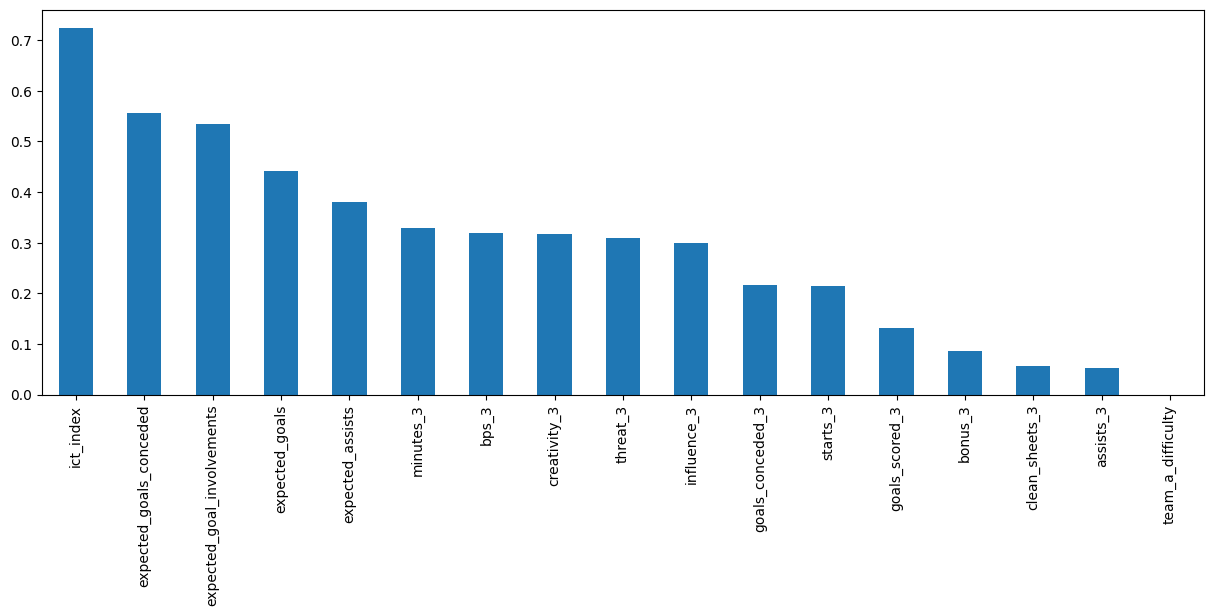

In [141]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

##### Select to 20% perct

In [142]:
from sklearn.feature_selection import SelectPercentile

## Selecting the top 20 percentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=50)
selected_top_columns.fit(k_sel_X_train, for_splits['target_train'])

selected_top_columns.get_support()

array([False,  True,  True,  True,  True,  True, False,  True, False,
       False, False, False, False, False, False,  True,  True])

In [143]:
for_20_columns = k_sel_X_train.columns[selected_top_columns.get_support()]

for_20_train = k_sel_X_train[for_20_columns]
for_20_test = k_sel_X_test[for_20_columns]


##### Model (MI)

###### Linear Model

In [144]:

MI_for_lin_reg = Linear_regression(for_20_train, for_20_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(MI_for_lin_reg =  [MI_for_lin_reg['train_RMSE'], MI_for_lin_reg['test_RMSE'], MI_for_lin_reg['cv_rmse'], MI_for_lin_reg['R2_train'], MI_for_lin_reg['R2_test']])

for_evaluation_stats

Training set RMSE: 1.1214880187531557
Test set RMSE: 1.2349793533810483
Training set R2: 0.8101661244575734
Test set R2: 0.7704306589923867
count    10.000000
mean      1.137865
std       0.142453
min       0.948847
25%       0.997894
50%       1.178538
75%       1.267047
max       1.302947
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg,MI_for_lin_reg
train_RMSE,1.116065,0.036669,0.645369,0.860099,1.116065,0.036669,0.646468,0.860099,1.119536,0.036691,0.652194,0.859895,1.121488
test_RMSE,1.230522,1.580673,1.219686,1.249217,1.230522,1.615640,1.219900,1.249217,1.228707,1.678146,1.206758,1.247320,1.234979
cv_rmse,1.149759,1.569550,1.147506,1.157798,1.149759,1.524163,1.139910,1.157798,1.145902,1.534893,1.141721,1.151140,1.137865
R2_train,0.811998,0.999797,0.937136,0.888344,0.811998,0.999797,0.936922,0.888344,0.810826,0.999797,0.935800,0.888397,0.810166
R2_test,0.772085,0.623921,0.776081,0.765107,0.772085,0.607099,0.776003,0.765107,0.772757,0.576109,0.780803,0.765820,0.770431


###### DecisionTree Model

In [145]:
MI_for_dt_reg = DecisionTreeRegression(for_20_train, for_20_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(MI_for_dt_reg = [MI_for_dt_reg['train_RMSE'], MI_for_dt_reg['test_RMSE'], MI_for_dt_reg['cv_rmse'], MI_for_dt_reg['R2_train'], MI_for_dt_reg['R2_test']])

for_evaluation_stats



Training set RMSE: 0.04541813099080289
Test set RMSE: 1.5663579787908504
Training set R2: 0.9996886542407177
Test set R2: 0.6307023527832576
count    10.000000
mean      1.425981
std       0.197518
min       1.145658
25%       1.307955
50%       1.375773
75%       1.520728
max       1.818011
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg,MI_for_lin_reg,MI_for_dt_reg
train_RMSE,1.116065,0.036669,0.645369,0.860099,1.116065,0.036669,0.646468,0.860099,1.119536,0.036691,0.652194,0.859895,1.121488,0.045418
test_RMSE,1.230522,1.580673,1.219686,1.249217,1.230522,1.615640,1.219900,1.249217,1.228707,1.678146,1.206758,1.247320,1.234979,1.566358
cv_rmse,1.149759,1.569550,1.147506,1.157798,1.149759,1.524163,1.139910,1.157798,1.145902,1.534893,1.141721,1.151140,1.137865,1.425981
R2_train,0.811998,0.999797,0.937136,0.888344,0.811998,0.999797,0.936922,0.888344,0.810826,0.999797,0.935800,0.888397,0.810166,0.999689
R2_test,0.772085,0.623921,0.776081,0.765107,0.772085,0.607099,0.776003,0.765107,0.772757,0.576109,0.780803,0.765820,0.770431,0.630702


###### RandomForest Model

In [146]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
MI_for_rf_reg = RandomForestRegression(for_20_train, for_20_test,
                               for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(MI_for_rf_reg = [MI_for_rf_reg['train_RMSE'], MI_for_rf_reg['test_RMSE'], MI_for_rf_reg['cv_rmse'], MI_for_rf_reg['R2_train'], MI_for_rf_reg['R2_test']])

for_evaluation_stats

count    10.000000
mean      1.130219
std       0.160523
min       0.910419
25%       0.994448
50%       1.141141
75%       1.268330
max       1.337951
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg,MI_for_lin_reg,MI_for_dt_reg,MI_for_rf_reg
train_RMSE,1.116065,0.036669,0.645369,0.860099,1.116065,0.036669,0.646468,0.860099,1.119536,0.036691,0.652194,0.859895,1.121488,0.045418,0.650720
test_RMSE,1.230522,1.580673,1.219686,1.249217,1.230522,1.615640,1.219900,1.249217,1.228707,1.678146,1.206758,1.247320,1.234979,1.566358,1.277393
cv_rmse,1.149759,1.569550,1.147506,1.157798,1.149759,1.524163,1.139910,1.157798,1.145902,1.534893,1.141721,1.151140,1.137865,1.425981,1.130219
R2_train,0.811998,0.999797,0.937136,0.888344,0.811998,0.999797,0.936922,0.888344,0.810826,0.999797,0.935800,0.888397,0.810166,0.999689,0.936090
R2_test,0.772085,0.623921,0.776081,0.765107,0.772085,0.607099,0.776003,0.765107,0.772757,0.576109,0.780803,0.765820,0.770431,0.630702,0.754391


###### XgBoost Model

In [147]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
MI_for_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(MI_for_xgb_reg = [MI_for_xgb_reg['train_RMSE'], MI_for_xgb_reg['test_RMSE'], MI_for_xgb_reg['cv_rmse'], MI_for_xgb_reg['R2_train'], MI_for_xgb_reg['R2_test']])
for_evaluation_stats

,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg,MI_for_lin_reg,MI_for_dt_reg,MI_for_rf_reg,MI_for_xgb_reg
train_RMSE,1.116065,0.036669,0.645369,0.860099,1.116065,0.036669,0.646468,0.860099,1.119536,0.036691,0.652194,0.859895,1.121488,0.045418,0.650720,0.859895
test_RMSE,1.230522,1.580673,1.219686,1.249217,1.230522,1.615640,1.219900,1.249217,1.228707,1.678146,1.206758,1.247320,1.234979,1.566358,1.277393,1.247320
cv_rmse,1.149759,1.569550,1.147506,1.157798,1.149759,1.524163,1.139910,1.157798,1.145902,1.534893,1.141721,1.151140,1.137865,1.425981,1.130219,1.151140
R2_train,0.811998,0.999797,0.937136,0.888344,0.811998,0.999797,0.936922,0.888344,0.810826,0.999797,0.935800,0.888397,0.810166,0.999689,0.936090,0.888397
R2_test,0.772085,0.623921,0.776081,0.765107,0.772085,0.607099,0.776003,0.765107,0.772757,0.576109,0.780803,0.765820,0.770431,0.630702,0.754391,0.765820


# Best Stats

In [148]:
gk_evaluation_stats

,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg,MI_gk_lin_reg,MI_gk_dt_reg,MI_gk_rf_reg,MI_gk_xgb_reg
train_RMSE,1.161926,0.035196,0.757658,0.892989,1.166336,0.035196,0.759153,0.892989,1.232308,0.117008,0.836169,0.961547,1.268165,1.085436,1.097823,0.961547
test_RMSE,1.235357,1.495157,1.152307,1.175463,1.241539,1.410694,1.154696,1.175463,1.286200,1.432425,1.136594,1.123488,1.301284,1.311391,1.313343,1.123488
cv_rmse,1.188035,1.507652,1.129481,1.107850,1.191555,1.509706,1.134954,1.107850,1.233383,1.501838,1.151050,1.121890,1.265201,1.255214,1.215899,1.121890
R2_train,0.623218,0.999654,0.839794,0.777451,0.620353,0.999654,0.839161,0.777451,0.576190,0.996179,0.804871,0.741968,0.551168,0.671193,0.663645,0.741968
R2_test,0.544742,0.333122,0.603897,0.587817,0.540174,0.406340,0.602252,0.587817,0.506497,0.387909,0.614626,0.623462,0.494855,0.486977,0.485449,0.623462


In [149]:
# Goalkeepers
#### XgBoost Model under the Variance threshold performed better


In [150]:
def_evaluation_stats

,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg,MI_def_xgb_reg
train_RMSE,1.528129,0.031296,1.144598,1.338167,1.528129,0.031296,1.144095,1.338167,1.537976,0.052255,1.187744,1.354777,1.561224,0.332285,1.266506,1.354777
test_RMSE,1.547962,2.110464,1.520657,1.504497,1.547962,2.060051,1.524286,1.504497,1.550029,2.108376,1.496682,1.494898,1.561262,2.041492,1.546156,1.494898
cv_rmse,1.536999,2.115961,1.486946,1.476898,1.536999,2.126267,1.487599,1.476898,1.538774,2.070915,1.484410,1.472449,1.559501,2.041158,1.506043,1.472449
R2_train,0.525298,0.999801,0.733678,0.635983,0.525298,0.999801,0.733912,0.635983,0.519161,0.999445,0.713221,0.626890,0.504514,0.977555,0.673927,0.626890
R2_test,0.521779,0.111076,0.538500,0.548257,0.521779,0.153037,0.536295,0.548257,0.520500,0.112835,0.552938,0.554003,0.513525,0.168228,0.522894,0.554003


In [151]:
# Defenders
#### Rf Model under the Variance threshold performed better

In [152]:
mid_evaluation_stats

,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg,MI_mid_lin_reg,MI_mid_dt_reg,MI_mid_rf_reg,MI_mid_xgb_reg
train_RMSE,1.205072,0.044234,0.834991,1.021547,1.205072,0.044234,0.834061,1.021547,1.213122,0.065749,0.868323,1.046002,1.250478,0.226383,1.009431,1.046002
test_RMSE,1.224586,1.614120,1.183569,1.201454,1.224586,1.623789,1.186505,1.201454,1.218829,1.684806,1.208846,1.214833,1.244995,1.652737,1.261288,1.214833
cv_rmse,1.212407,1.599599,1.155467,1.153411,1.212407,1.610269,1.155957,1.153411,1.213660,1.624869,1.163703,1.156576,1.248435,1.685087,1.261543,1.156576
R2_train,0.746038,0.999658,0.878071,0.817502,0.746038,0.999658,0.878343,0.817502,0.742634,0.999244,0.868143,0.808659,0.726540,0.991037,0.821805,0.808659
R2_test,0.753078,0.571003,0.769342,0.762318,0.753078,0.565849,0.768196,0.762318,0.755394,0.532607,0.759384,0.756995,0.744779,0.550231,0.738055,0.756995


In [153]:
# Midfielders
#### RF Model under the Variance threshold performed better

In [154]:
for_evaluation_stats

,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg,MI_for_lin_reg,MI_for_dt_reg,MI_for_rf_reg,MI_for_xgb_reg
train_RMSE,1.116065,0.036669,0.645369,0.860099,1.116065,0.036669,0.646468,0.860099,1.119536,0.036691,0.652194,0.859895,1.121488,0.045418,0.650720,0.859895
test_RMSE,1.230522,1.580673,1.219686,1.249217,1.230522,1.615640,1.219900,1.249217,1.228707,1.678146,1.206758,1.247320,1.234979,1.566358,1.277393,1.247320
cv_rmse,1.149759,1.569550,1.147506,1.157798,1.149759,1.524163,1.139910,1.157798,1.145902,1.534893,1.141721,1.151140,1.137865,1.425981,1.130219,1.151140
R2_train,0.811998,0.999797,0.937136,0.888344,0.811998,0.999797,0.936922,0.888344,0.810826,0.999797,0.935800,0.888397,0.810166,0.999689,0.936090,0.888397
R2_test,0.772085,0.623921,0.776081,0.765107,0.772085,0.607099,0.776003,0.765107,0.772757,0.576109,0.780803,0.765820,0.770431,0.630702,0.754391,0.765820


In [155]:
# Forwards
#### RF Model under the KBest performed better


## Fine tuning the models

### XgBoost (Goalkeepers and Forwards)

In [156]:

from sklearn.model_selection import GridSearchCV
import numpy as np

# =========================================================================
# XGBoost regression:
# Parameters:
# n_estimators  "Number of gradient boosted trees. Equivalent to number
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make
#                the model more complex and more likely to overfit."
# =========================================================================
regressor = xgb(eval_metric='rmsle')

# =========================================================================
# exhaustively search for the optimal hyperparameters
# =========================================================================
# set up our search grid
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": np.arange(100, 1000, 50),
              "learning_rate": np.arange(0.01, .2, 0.005)}


In [157]:
# try out every combination of the above values
goalkeepers_search = GridSearchCV(regressor, param_grid, cv=5).fit(
    gk_threshold_train, gk_splits['target_train'])

print("The best hyperparameters are ", goalkeepers_search.best_params_)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-157-e6d530c6dfbc>", line 2, in <cell line: 2>
    goalkeepers_search = GridSearchCV(regressor, param_grid, cv=5).fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 898, in fit
    self._run_search(evaluate_candidates)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 1422, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 845, in evaluate_candidates
    out = parallel(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", l

TypeError: object of type 'NoneType' has no len()

In [1]:
model = RandomForestRegressor()

param_grid = {'n_estimators': [8, 10, 12, 14, 16, 18, 20]}

# Define the possible values of the hyperparameter
grid = {
    'n_estimators': [8, 10, 12, 14, 16, 18, 20, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'random_state': [18]
}

NameError: name 'RandomForestRegressor' is not defined

In [2]:
def_grid_search = GridSearchCV(model, grid, cv=5,
                              scoring='neg_root_mean_squared_error')
def_grid_search.fit(def_threshold_train, def_splits['target_train'])

print("The best defender hyperparameters are ", def_grid_search.best_params_)

NameError: name 'GridSearchCV' is not defined

In [ ]:
# Deine the model with cv=5 for a 5-fold cross validation
# GridSearchCV has the best_estimator_ parameter that returns the  estimator
# which gave highest score (or smallest loss if specified)

mid_grid_search = GridSearchCV(model, grid, cv=5,
                              scoring='neg_root_mean_squared_error')
mid_grid_search.fit(mid_threshold_train, mid_splits['target_train'])


print("The best midfielder hyperparameters are ", mid_grid_search.best_params_)

In [ ]:

forwards_search = GridSearchCV(regressor, param_grid, cv=5).fit(
    for_20_train, for_splits['target_train'])


print("The best midfielder hyperparameters are ", forwards_search.best_params_)

## With the hyperparameters

### Goalkeepers

In [ ]:
hyperparameters = {'learning_rate': 0.024999999999999998, 'max_depth': 4, 'n_estimators': 100} # {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
FT_for_xgb_reg = XGBoostRegression(for_threshold_train, for_threshold_test, for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = for_evaluation_stats.assign(FT_for_xgb_reg = [FT_for_xgb_reg['train_RMSE'], FT_for_xgb_reg['test_RMSE'], FT_for_xgb_reg['cv_rmse'], FT_for_xgb_reg['R2_train'], FT_for_xgb_reg['R2_test']])
gk_evaluation_stats